# Natural Gas Future

In [1]:
# Print multiple objects to screen in same shell 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display, HTML

import pandas as pd
import os
import sys
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error
from math import sqrt
import scipy.stats as scs
from arch import arch_model

from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline
p = print

In [2]:
naturalgas = pd.read_csv("Natural_Gas_Futures_Contract_2.csv")

In [3]:
naturalgas.head(5)

,Day,Natural Gas Futures Contract 1 Dollars per Million Btu
0,12/29/2017,2.953
1,12/28/2017,2.914
2,12/27/2017,2.738
3,12/26/2017,2.643
4,12/22/2017,2.667


# Part 1 Data Preperation

## 1.1 Reorder the data

In [4]:
naturalgas['Day'] =pd.to_datetime(naturalgas['Day'])
naturalgas.head(5)

,Day,Natural Gas Futures Contract 1 Dollars per Million Btu
0,2017-12-29,2.953
1,2017-12-28,2.914
2,2017-12-27,2.738
3,2017-12-26,2.643
4,2017-12-22,2.667


In [5]:
naturalgas=naturalgas.sort_values(by='Day')
naturalgas.head(5)
naturalgas.count()

,Day,Natural Gas Futures Contract 1 Dollars per Million Btu
6001,1994-01-13,2.194
6000,1994-01-14,2.268
5999,1994-01-17,2.360
5998,1994-01-18,2.318
5997,1994-01-19,2.252


Day                                                        6002
Natural Gas Futures Contract 1  Dollars per Million Btu    6002
dtype: int64

## 1.2 Impute missing value

In [6]:
Date = pd.bdate_range('1994-01-13', '2017-12-29')
type(Date)
Date = Date.strftime('%Y-%m-%d')
Date = pd.DataFrame(Date)
Date.head(5)

pandas.core.indexes.datetimes.DatetimeIndex

,0
0,1994-01-13
1,1994-01-14
2,1994-01-17
3,1994-01-18
4,1994-01-19


In [7]:
Date.columns = ['Day']
Date.head(5)
Date.tail(5)

,Day
0,1994-01-13
1,1994-01-14
2,1994-01-17
3,1994-01-18
4,1994-01-19


,Day
6247,2017-12-25
6248,2017-12-26
6249,2017-12-27
6250,2017-12-28
6251,2017-12-29


In [8]:
Date['Day'] =pd.to_datetime(Date['Day'])
Date.count()

Day    6252
dtype: int64

In [9]:
gas = pd.merge(Date, naturalgas, how='left', on=['Day'])
gas.count()
gas.head()

Day                                                        6252
Natural Gas Futures Contract 1  Dollars per Million Btu    6002
dtype: int64

,Day,Natural Gas Futures Contract 1 Dollars per Million Btu
0,1994-01-13,2.194
1,1994-01-14,2.268
2,1994-01-17,2.360
3,1994-01-18,2.318
4,1994-01-19,2.252


In [10]:
gas.columns = ['Day','Price']
gas['Price'].isnull().sum()

250

In [11]:
gas = gas.fillna(method='ffill')
gas['Price'].isnull().sum()

0

In [12]:
gas.to_csv("gas4.csv", index= False)

## 1.3 Plotting

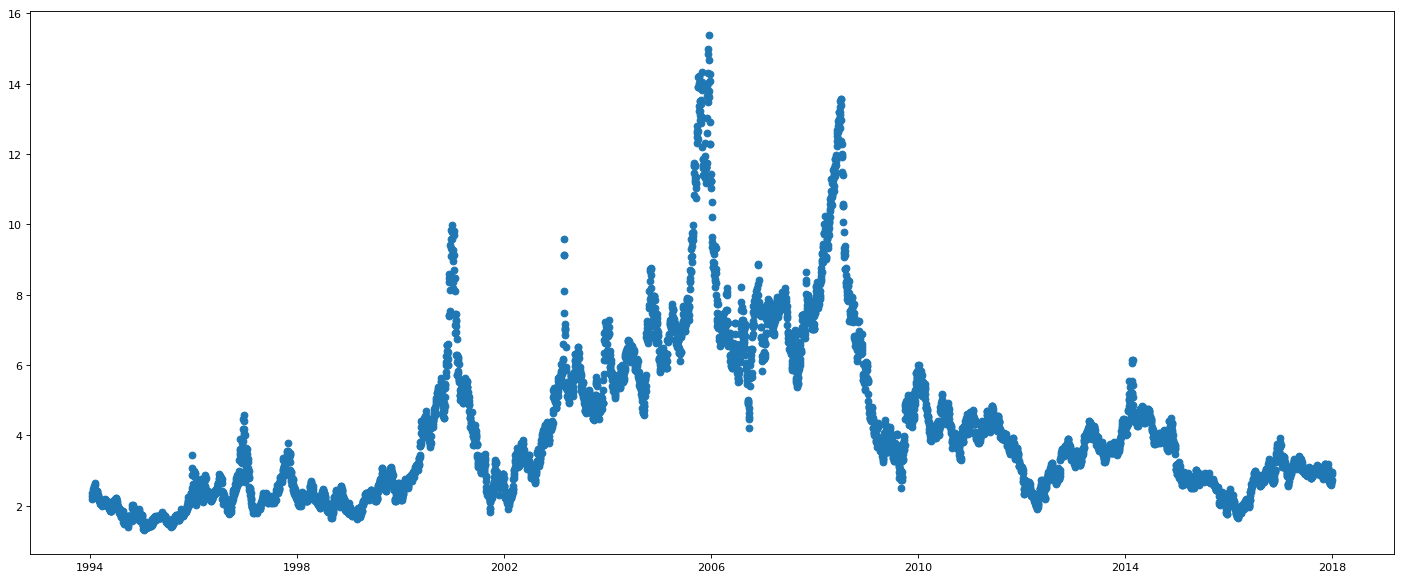

In [13]:
fig=plt.figure(figsize=(22, 9), dpi= 80, facecolor='w', edgecolor='k')
plt.plot_date(x=gas.Day, y=gas.Price)
plt.show()

# Part 2 Modeling

## 2.1 Split into training and testing data. Testing data starts from 2017-01-02.

In [3]:
df = pd.read_csv('gas4.csv')

In [4]:
#df.Timestamp = pd.to_datetime(df.Day) 
#df.index = df.Timestamp
df.Timestamp = pd.date_range('1994-1-13', periods=6252, freq='B')
df.index = df.Timestamp

In [5]:
df.index

DatetimeIndex(['1994-01-13', '1994-01-14', '1994-01-17', '1994-01-18',
               '1994-01-19', '1994-01-20', '1994-01-21', '1994-01-24',
               '1994-01-25', '1994-01-26',
               ...
               '2017-12-18', '2017-12-19', '2017-12-20', '2017-12-21',
               '2017-12-22', '2017-12-25', '2017-12-26', '2017-12-27',
               '2017-12-28', '2017-12-29'],
              dtype='datetime64[ns]', length=6252, freq='B')

In [7]:
train=df[0:5992] 
test=df[5992:]
train.tail(5)
test.head(5)

,Day,Price
2016-12-26,2016-12-26,3.662
2016-12-27,2016-12-27,3.761
2016-12-28,2016-12-28,3.930
2016-12-29,2016-12-29,3.802
2016-12-30,2016-12-30,3.724


,Day,Price
2017-01-02,2017-01-02,3.724
2017-01-03,2017-01-03,3.327
2017-01-04,2017-01-04,3.267
2017-01-05,2017-01-05,3.273
2017-01-06,2017-01-06,3.285


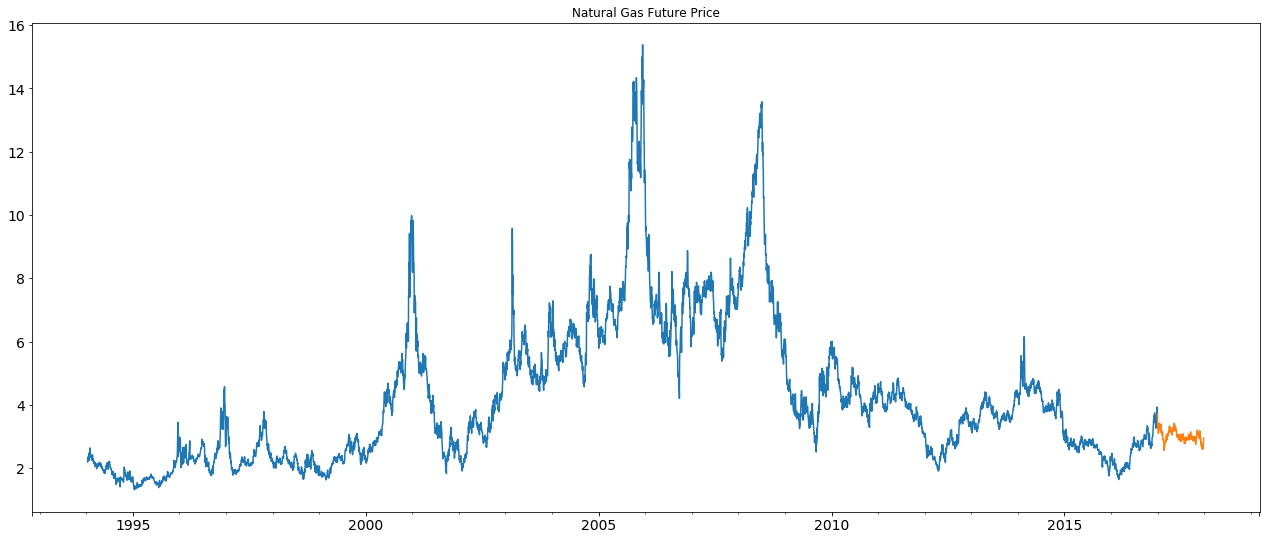

In [21]:
train.Price.plot(figsize=(22,9), title= 'Natural Gas Future Price', fontsize=14)
test.Price.plot(figsize=(22,9), title= 'Natural Gas Future Price', fontsize=14)
plt.show()

## 2.2 Time series analysis

In [22]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

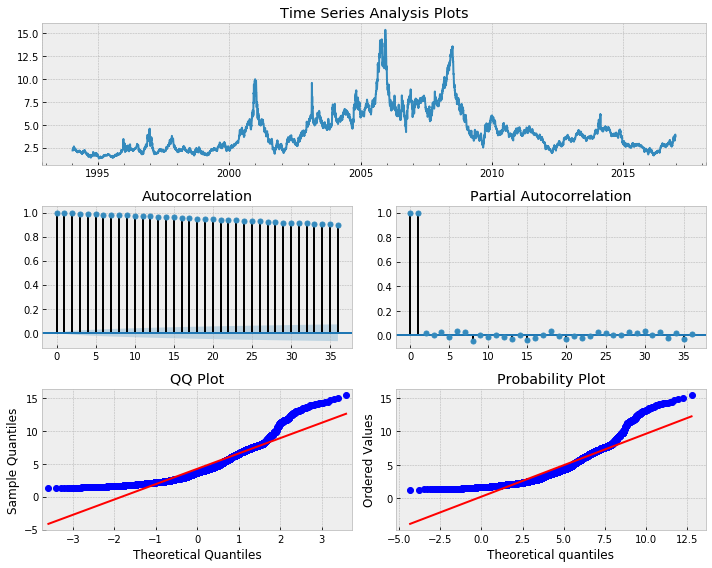

In [23]:
tsplot(train.Price, lags=36)

## 2.3 ARIMA

In [24]:
model1 = ARIMA(df.Price, order=(1, 1, 1))
fit1 = model1.fit()
print(fit1.summary())

/Users/shaozhao/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/shaozhao/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


                             ARIMA Model Results                              
Dep. Variable:                D.Price   No. Observations:                 6251
Model:                 ARIMA(1, 1, 1)   Log Likelihood                2142.492
Method:                       css-mle   S.D. of innovations              0.172
Date:                Thu, 03 May 2018   AIC                          -4276.983
Time:                        03:50:21   BIC                          -4250.021
Sample:                    01-14-1994   HQIC                         -4267.639
                         - 12-29-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0001      0.002      0.058      0.954      -0.004       0.004
ar.L1.D.Price     0.6081      0.180      3.372      0.001       0.255       0.961
ma.L1.D.Price    -0.6299      0.176     

In [25]:
model2 = ARIMA(df.Price, order=(1,1,1))
fit2 = model2.fit(trend='nc')
print(fit2.summary())

/Users/shaozhao/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/shaozhao/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


                             ARIMA Model Results                              
Dep. Variable:                D.Price   No. Observations:                 6251
Model:                 ARIMA(1, 1, 1)   Log Likelihood                2142.490
Method:                       css-mle   S.D. of innovations              0.172
Date:                Thu, 03 May 2018   AIC                          -4278.980
Time:                        03:50:22   BIC                          -4258.758
Sample:                    01-14-1994   HQIC                         -4271.972
                         - 12-29-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
ar.L1.D.Price     0.6081      0.180      3.372      0.001       0.255       0.962
ma.L1.D.Price    -0.6298      0.176     -3.573      0.000      -0.975      -0.284
                                    Root

/Users/shaozhao/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


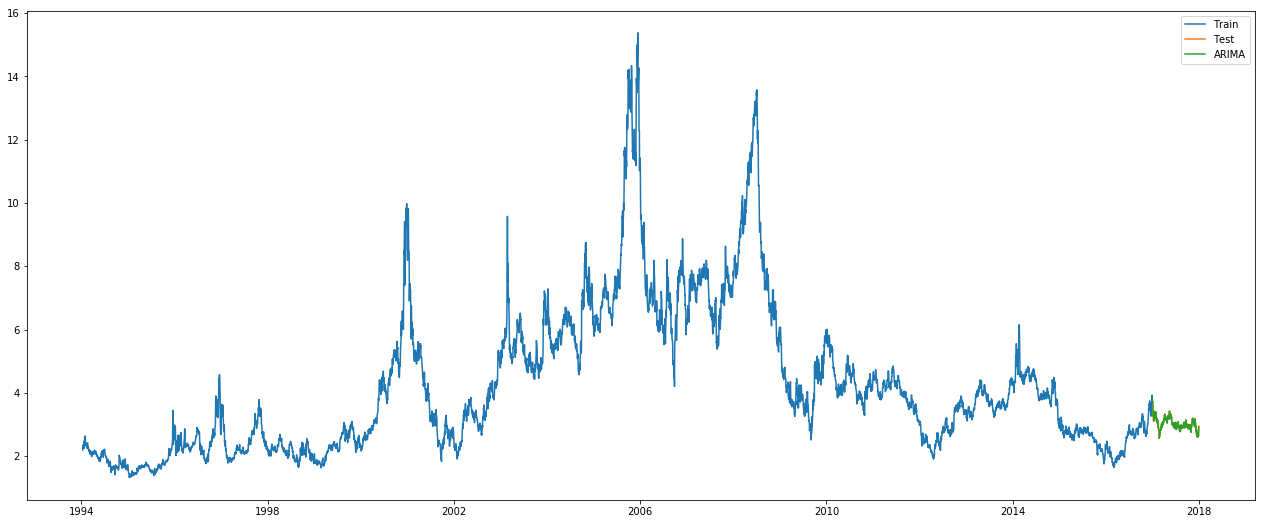

In [26]:
y_hat_avg = test.copy()
y_hat_avg['ARIMA'] = fit2.predict(test.index[0],test.index[-1],typ='levels')
plt.figure(figsize=(22,9))
plt.plot(train['Price'], label='Train')
plt.plot(test['Price'], label='Test')
plt.plot(y_hat_avg['ARIMA'], label='ARIMA')
plt.legend(loc='best')
plt.show()

In [27]:
rms = sqrt(mean_squared_error(test.Price, y_hat_avg.ARIMA))
print(rms)

0.0728251793669277


/Users/shaozhao/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


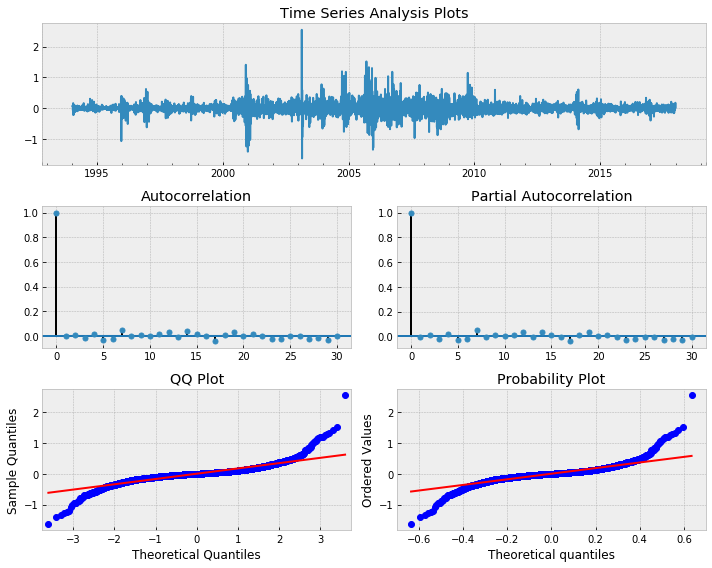

In [28]:
tsplot(fit2.resid, lags=30)

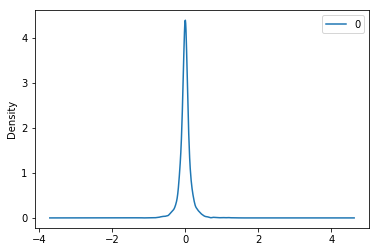

                 0
count  6251.000000
mean      0.000127
std       0.171769
min      -1.626668
25%      -0.063912
50%      -0.000656
75%       0.060292
max       2.543392


In [29]:
residuals = pd.DataFrame(fit2.resid)
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

## 2.4 Simple Exponential Smoothing

In [30]:
model3 = SimpleExpSmoothing(np.asarray(df['Price']))
fit3 = model3.fit()
fit3.model.params['smoothing_level']

0.9776533839746111

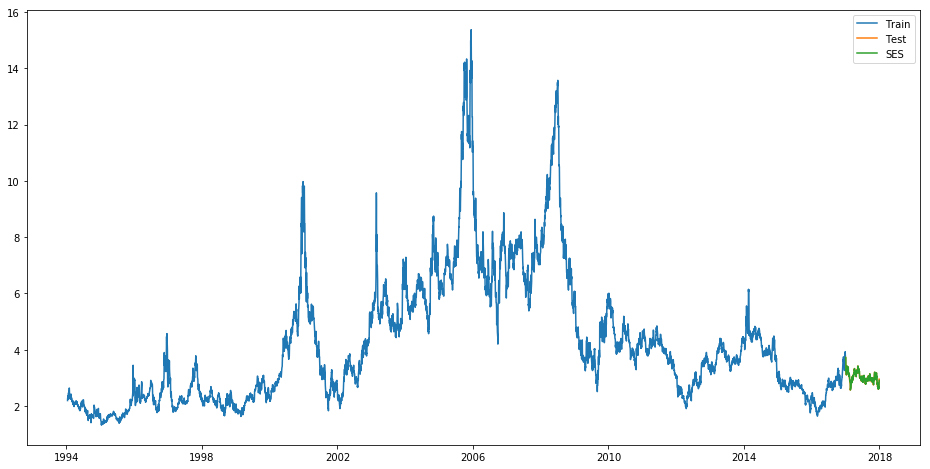

In [31]:
y_hat_avg3 = test.copy()
y_hat_avg3['SES'] = fit3.fittedvalues[5992:]
plt.figure(figsize=(16,8))
plt.plot(train['Price'], label='Train')
plt.plot(test['Price'], label='Test')
plt.plot(y_hat_avg3['SES'], label='SES')
plt.legend(loc='best')
plt.show()

In [32]:
rms = sqrt(mean_squared_error(test.Price, y_hat_avg3.SES))
print(rms)

0.0728712652480168


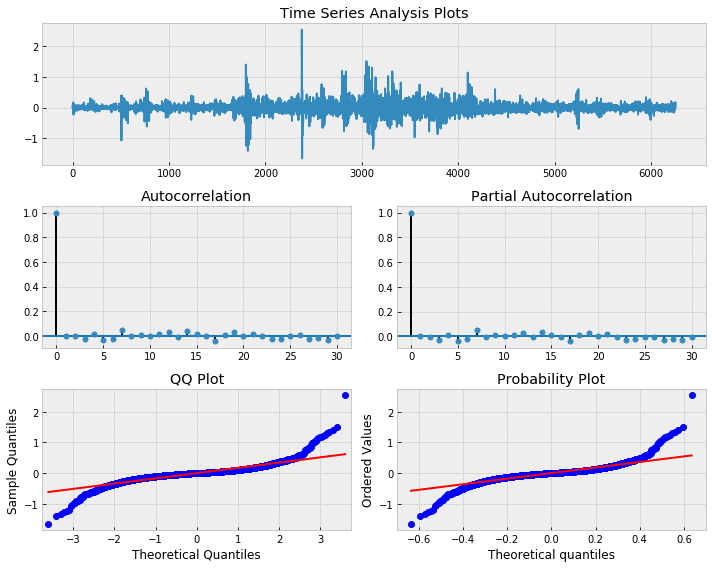

In [33]:
tsplot(fit3.resid, lags=30)

## 2.5 Holt's linear Smoothing

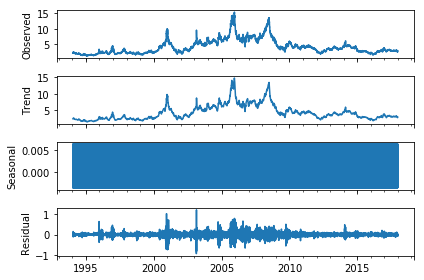

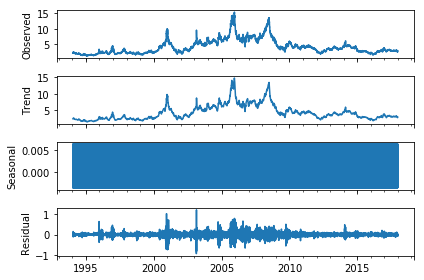

In [34]:
import statsmodels.api as sm
sm.tsa.seasonal_decompose(df.Price).plot()
result = sm.tsa.stattools.adfuller(df.Price)
plt.show()

In [35]:
model4 = Holt(np.asarray(df['Price']))
fit4 = model4.fit()
print(fit4.model.params['smoothing_level'])
print(fit4.model.params['smoothing_slope'])

1.0
0.0


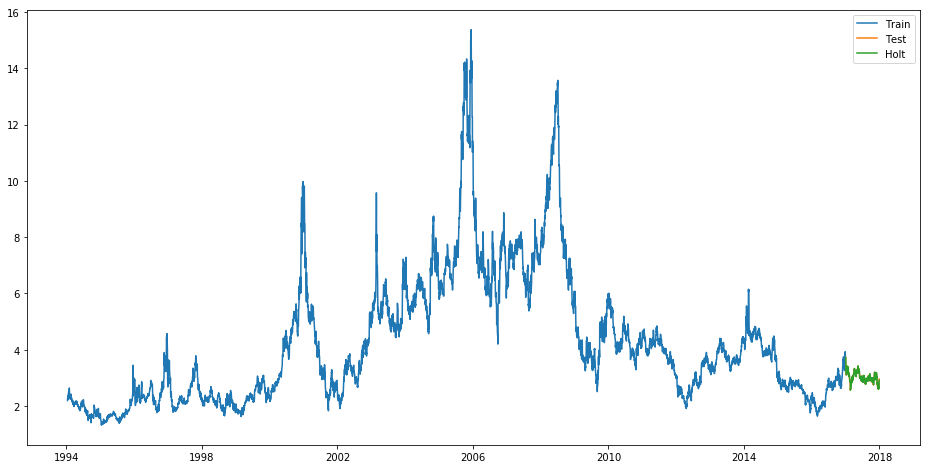

In [36]:
y_hat_avg4 = test.copy()
y_hat_avg4['Holt'] = fit4.fittedvalues[5992:]
plt.figure(figsize=(16,8))
plt.plot(train['Price'], label='Train')
plt.plot(test['Price'], label='Test')
plt.plot(y_hat_avg4['Holt'], label='Holt')
plt.legend(loc='best')
plt.show()

In [37]:
rms = sqrt(mean_squared_error(test.Price, y_hat_avg4.Holt))
print(rms)

0.07293266124942295


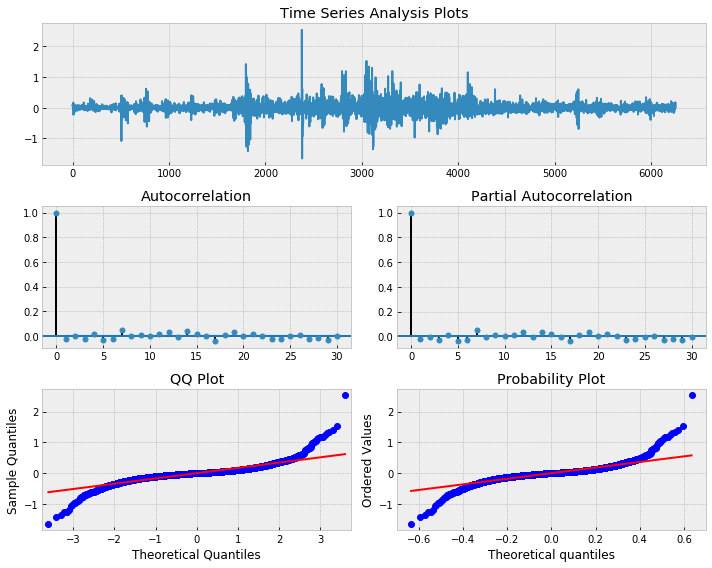

In [38]:
tsplot(fit4.resid, lags=30)

## 2.6 Backtesting

### For ARIMA Model

In [8]:
result = test.copy()
result['ARIMA']=np.nan
j = 0

In [9]:
for i in range (5992,6252):
    forecast = ARIMA(df.Price[0:i], order=(1,1,1)).fit(trend='nc').forecast()[0]
    result.iloc[j,2]=forecast
    j = j+1

result.head()

,Day,Price,ARIMA
2017-01-02,2017-01-02,3.724,3.725091
2017-01-03,2017-01-03,3.327,3.724682
2017-01-04,2017-01-04,3.267,3.335980
2017-01-05,2017-01-05,3.273,3.273891
2017-01-06,2017-01-06,3.285,3.277196


In [10]:
rms = sqrt(mean_squared_error(result.Price, result.ARIMA))
print(rms)

0.07282762159490226


In [11]:
result['Price'].corr(result['ARIMA'])

0.92241586830767808

### For Simple Exponential Smoothing

In [12]:
result['SES']=np.nan
j = 0

In [13]:
result.head()

,Day,Price,ARIMA,SES
2017-01-02,2017-01-02,3.724,3.725091,NaN
2017-01-03,2017-01-03,3.327,3.724682,NaN
2017-01-04,2017-01-04,3.267,3.335980,NaN
2017-01-05,2017-01-05,3.273,3.273891,NaN
2017-01-06,2017-01-06,3.285,3.277196,NaN


In [14]:
for i in range (5992,6252):
    forecast = SimpleExpSmoothing(np.asarray(df.Price[0:i])).fit().forecast(1)
    result.iloc[j,3]=forecast
    j = j+1
    
result.head()

,Day,Price,ARIMA,SES
2017-01-02,2017-01-02,3.724,3.725091,3.725788
2017-01-03,2017-01-03,3.327,3.724682,3.724040
2017-01-04,2017-01-04,3.267,3.335980,3.335790
2017-01-05,2017-01-05,3.273,3.273891,3.268511
2017-01-06,2017-01-06,3.285,3.277196,3.272901


In [15]:
rms = sqrt(mean_squared_error(result.Price, result.SES))
print(rms)

0.07287240049604032


In [16]:
result['Price'].corr(result['SES'])

0.92244000436881168

### For Holt Linear Smoothing

In [17]:
result['Holt']=np.nan
j = 0

In [18]:
result.head()

,Day,Price,ARIMA,SES,Holt
2017-01-02,2017-01-02,3.724,3.725091,3.725788,NaN
2017-01-03,2017-01-03,3.327,3.724682,3.724040,NaN
2017-01-04,2017-01-04,3.267,3.335980,3.335790,NaN
2017-01-05,2017-01-05,3.273,3.273891,3.268511,NaN
2017-01-06,2017-01-06,3.285,3.277196,3.272901,NaN


In [19]:
for i in range (5992,6252):
    forecast = Holt(np.asarray(df.Price[0:i])).fit().forecast(1)
    result.iloc[j,4]=forecast
    j = j+1
    
result.head()

,Day,Price,ARIMA,SES,Holt
2017-01-02,2017-01-02,3.724,3.725091,3.725788,3.724
2017-01-03,2017-01-03,3.327,3.724682,3.724040,3.724
2017-01-04,2017-01-04,3.267,3.335980,3.335790,3.327
2017-01-05,2017-01-05,3.273,3.273891,3.268511,3.267
2017-01-06,2017-01-06,3.285,3.277196,3.272901,3.273


In [20]:
rms = sqrt(mean_squared_error(result.Price, result.Holt))
print(rms)

0.07293266124942295


In [21]:
result['Price'].corr(result['Holt'])

0.92240388872124535

# Part 3 Strategy

## User-Defined Function - Measurement

In [32]:
#Measurement
def show(result):
    #Data preparation
    result=result.fillna(0)
    result['Total profit'] = result.profit + result.profit2 #9
    profit=result.iloc[0:260,[0,9]]
    profit=profit.rename(columns = {'Total profit':'Profit'})
    hhgas=pd.read_csv("Henry_Hub_Natural_Gas_Spot_Price.csv")
    hhgas['Day'] =pd.to_datetime(hhgas['Day'], format='%m/%d/%y')

    ##Statistics
    ###Daily return
    profit['Return']=np.nan #9
    #t = 1
    for i in range(0, 260):
        if result.iloc[i,2] == 'buy':
            profit.iloc[i,2] = result.iloc[i,4]/result.iloc[i,1]
            #t = t * (1+profit.iloc[i,2])
        elif result.iloc[i,5] == 'sell':
            profit.iloc[i,2] = result.iloc[i,7]/result.iloc[i,1]
            #t = t * (1+profit.iloc[i,2])

    ###Benchmark - Henry Hub
    numrows = hhgas.iloc[1:,2].count()
    #rf = (hhgas.iloc[1:,2] + 1).prod() ** (1./numrows) - 1
    #rfsd = hhgas.iloc[1:,2].std()
    rf = hhgas.Return.mean()
    rfsd = hhgas.Return.std()
    
    merge=pd.merge(profit,hhgas,how="left", on="Day")

    temp = {'Total profit':[result.profit.sum()+result.profit2.sum()],
            'Yearly return':[profit.Return.mean()],
            'Min':[min(result.profit.min(),result.profit2.min())],
            'Max':[max(result.profit.max(),result.profit2.max())],
            'BM':[rf],
            'Sharpe':[(profit.Return.mean()-rf)/profit.Return.std()],
            'Sortino':[(profit.Return.mean()-rf)/profit.loc[profit['Return'] < 0].Return.std()],
            'Volatility':[profit.Return.std()],
            'BVolatility':[rfsd],
            '%BM+':[sum(n > 0 for n in merge['Return_x']-merge['Return_y']) / min(merge.Return_x.count(),merge.Return_y.count())],
            'P/L':[-profit.loc[profit['Return'] > 0].Return.sum()/profit.loc[profit['Return'] < 0].Return.sum()],
            'NProfit':[sum(n > 0 for n in profit.Return)],
            'NLoss':[sum(n < 0 for n in profit.Return)],
            'NP%':[sum(n > 0 for n in profit.Return)/(sum(n > 0 for n in profit.Return)+sum(n < 0 for n in profit.Return))]}

    #Show dataframe
    temp2 = pd.DataFrame(temp, columns=['Total profit','Yearly return','Min','Max',
                                        'BM','Sharpe','Sortino','Volatility', 'BVolatility',
                                        '%BM+','P/L','NProfit','NLoss','NP%'])
    ##display(HTML(temp2.to_html()))
    display(temp2)
    
    #Cumulative
    fig=plt.figure(figsize=(18, 7), dpi=100, facecolor='w', edgecolor='b')
    plt.plot(profit.Profit.cumsum())
    plt.show()

    #Profit in descending order
    profit.Profit.sort_values(ascending=False).plot(kind='bar', figsize=(18,7))
    ax1 = plt.axes()
    x_axis = ax1.axes.get_xaxis()
    x_axis.set_visible(False)
    plt.show()
    
    return();

In [44]:
#eb should be from 2016-12-30 to 2018-02-12
def flow(eb):
    eb['flow'] = 0 #7
    for i in range(0,260):
        if eb.iloc[i,2]=='buy':
            eb.iloc[i,7]-=eb.iloc[i,1]
            eb.iloc[eb.index.get_loc(eb.iloc[i,3]),7]+=eb.iloc[eb.index.get_loc(eb.iloc[i,3]),1]
        elif eb.iloc[i,4]=='sell':
            eb.iloc[i,7]+=eb.iloc[i,1]
            eb.iloc[eb.index.get_loc(eb.iloc[i,5]),7]-=eb.iloc[eb.index.get_loc(eb.iloc[i,5]),1]
        #Part only for fixed two-day opening strategy
        #'openning' from at least the second trading day
        if eb.iloc[i,6]=='opening':
            #hard-code to traceback
            if eb.iloc[i-1,2]=='buy':
                eb.iloc[i,7]-=eb.iloc[i,1]
                #eb.iloc[eb.index.get_loc(eb.iloc[i-1,3]),7]+=eb.iloc[eb.index.get_loc(eb.iloc[i-1,3]),1]
                eb.iloc[i+1,7]+=eb.iloc[i+1,1]
            elif eb.iloc[i-1,2]=='sell':
                eb.iloc[i,7]+=eb.iloc[i,1]
                #eb.iloc[eb.index.get_loc(eb.iloc[i-1,5]),7]+=eb.iloc[eb.index.get_loc(eb.iloc[i-1,5]),1]
                eb.iloc[i+1,7]-=eb.iloc[i+1,1]
    
    #Minimum beginning balance
    print('Minimum beginning balance =',abs(eb.flow.cumsum().min()+min(eb.iloc[eb.index.get_loc('2017-01-02'),7],0)))
    #plot
    fig=plt.figure(figsize=(18, 7), dpi=100, facecolor='w', edgecolor='b')
    plt.plot(eb.flow.cumsum())
    plt.show()
    
    return();

In [4]:
df=pd.read_csv('gas5.csv')
df.Timestamp=pd.date_range('1994-01-13', periods=6283, freq='B')
df.index=df.Timestamp
df.index
df['Day'] =pd.to_datetime(df['Day'],format='%d/%m/%Y')

/Users/shaozhao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


DatetimeIndex(['1994-01-13', '1994-01-14', '1994-01-17', '1994-01-18',
               '1994-01-19', '1994-01-20', '1994-01-21', '1994-01-24',
               '1994-01-25', '1994-01-26',
               ...
               '2018-01-30', '2018-01-31', '2018-02-01', '2018-02-02',
               '2018-02-05', '2018-02-06', '2018-02-07', '2018-02-08',
               '2018-02-09', '2018-02-12'],
              dtype='datetime64[ns]', length=6283, freq='B')

## 3.1 Fixed Policy

### 3.1.1 Fixed One-day strategy

In [5]:
def fixed_1_buy(price, dataframe, alpha):
    a = ARIMA(dataframe, order=(1,1,1)).fit(trend='nc').forecast(steps=1, alpha=alpha)
    if price <= a[2][0][0]:
        return('buy')
    else:
        return('no buy')

In [6]:
def fixed_1_sell(price, dataframe, alpha):
    a = ARIMA(dataframe, order=(1,1,1)).fit(trend='nc').forecast(steps=1, alpha=alpha)
    if price >= a[2][0][1]:
        return('sell')
    else:
        return('no sell')

#### 3.1.1.a Fixed One-day strategy with no risk control

In [7]:
result1 = df[5992:].copy()
result1['buy']=np.nan #2
result1['buy_r']=np.nan #3
result1['profit']=np.nan #4
result1['sell']=np.nan #5
result1['sell_r']=np.nan #6
result1['profit2']=np.nan #7
result1['opening']='no opening' #8
###

for i in range(0, 260):
    result1.iloc[i,2] = fixed_1_buy(result1.iloc[i,1], df.Price[0:i+5993], 1)
    result1.iloc[i,5] = fixed_1_sell(result1.iloc[i,1], df.Price[0:i+5993], 1)
    if result1.iloc[i,2] == 'buy':
        result1.iloc[i,3] = result1.iloc[i+1,0]
        result1.iloc[i,4] = result1.iloc[i+1,1]-result1.iloc[i,1]
    elif result1.iloc[i,5] == 'sell':
        result1.iloc[i,6] = result1.iloc[i+1,0]
        result1.iloc[i,7] = -result1.iloc[i+1,1]+result1.iloc[i,1]

/Users/shaozhao/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/shaozhao/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/shaozhao/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


In [8]:
result1.to_csv("result1.csv")

Last contract cleared on 01, Jan 2018


,Total profit,Yearly return,Min,Max,BM,Sharpe,Sortino,Volatility,BVolatility,%BM+,P/L,NProfit,NLoss,NP%
0,1.409,0.001779,-0.397,0.214,0.000491,0.054195,0.07262,0.023759,0.032503,0.496124,1.22234,141,107,0.568548


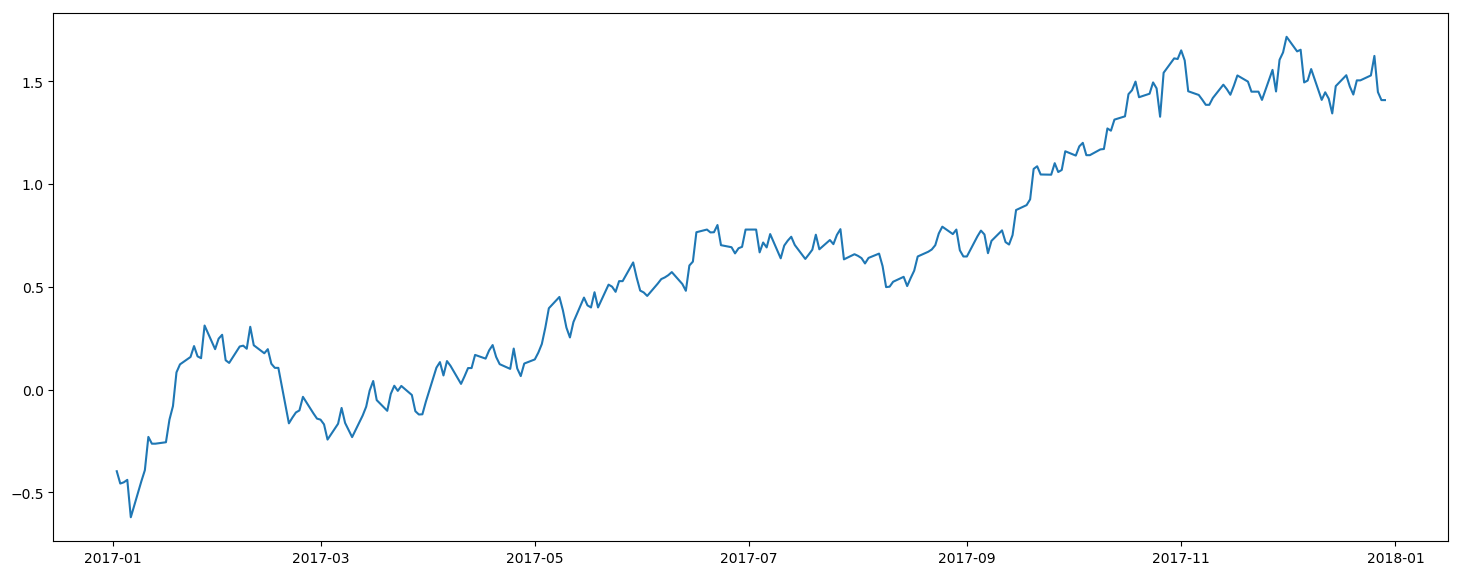

/Users/shaozhao/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


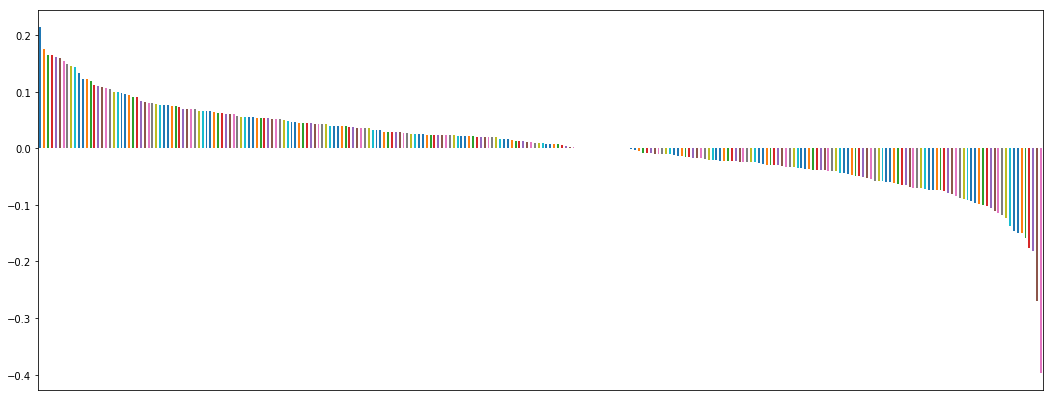

()

Minimum beginning balance = 7.4479999999999995


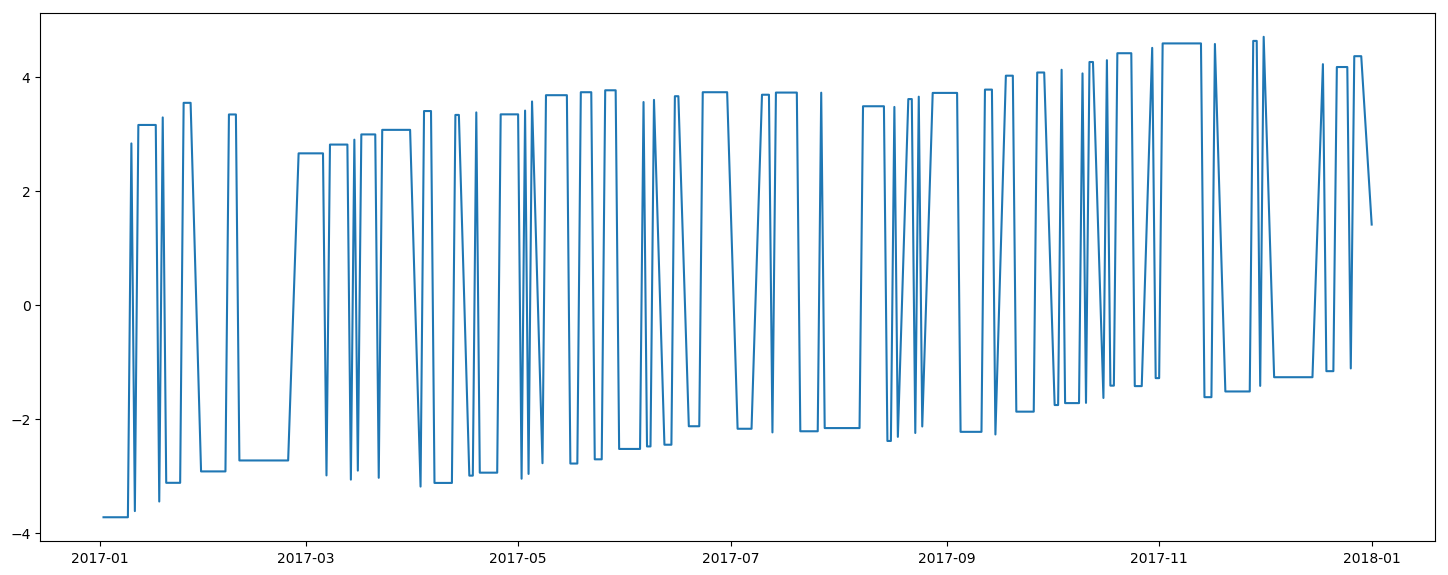

()

In [45]:
#Output
#Index of last trading day
ltd = max(result1.index.get_loc(result1.loc[result1['Day']==result1['buy_r'].last_valid_index()]['buy_r'][0]),
          result1.index.get_loc(result1.loc[result1['Day']==result1['sell_r'].last_valid_index()]['sell_r'][0]))

print(result1.iloc[ltd,0].strftime('Last contract cleared on %d, %b %Y'))

show(result1.loc[result1['Day'].isin(pd.date_range('2017-01-02','2017-12-29'))])
flow(result1.iloc[:ltd+1,[0,1,2,3,5,6,8]])

#### 3.1.1.b Fixed One-day strategy with risk control

In [10]:
result2 = df[5992:].copy()
result2['buy']=np.nan #2
result2['buy_r']=np.nan #3
result2['profit']=np.nan #4
result2['sell']=np.nan #5
result2['sell_r']=np.nan #6
result2['profit2']=np.nan #7
result2['opening']='no opening' #8
###

for i in range(0, 260):
    result2.iloc[i,2] = fixed_1_buy(result2.iloc[i,1], df.Price[0:i+5993], 1)
    result2.iloc[i,5] = fixed_1_sell(result2.iloc[i,1], df.Price[0:i+5993], 1)
    if result2.iloc[i,2] == 'buy':
        if result2.iloc[i+1,1]-result2.iloc[i,1] >= 0:
            result2.iloc[i,3] = result2.iloc[i+1,0]
            result2.iloc[i,4] = result2.iloc[i+1,1]-result2.iloc[i,1]
        else:
            #skip one period
            result2.iloc[i,3] = result2.iloc[i+2,0]
            result2.iloc[i,4] = result2.iloc[i+2,1]-result2.iloc[i,1]
    elif result2.iloc[i,5] == 'sell':
        if -result2.iloc[i+1,1]+result2.iloc[i,1] >= 0:
            result2.iloc[i,6] = result2.iloc[i+1,0]
            result2.iloc[i,7] = -result2.iloc[i+1,1]+result2.iloc[i,1]
        else:
            #skip one period
            result2.iloc[i,6] = result2.iloc[i+2,0]
            result2.iloc[i,7] = -result2.iloc[i+2,1]+result2.iloc[i,1]

/Users/shaozhao/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/shaozhao/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/shaozhao/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


In [11]:
result2.to_csv("result2.csv")

Last contract cleared on 01, Jan 2018


,Total profit,Yearly return,Min,Max,BM,Sharpe,Sortino,Volatility,BVolatility,%BM+,P/L,NProfit,NLoss,NP%
0,2.781,0.003497,-0.457,0.214,0.000491,0.116417,0.140843,0.025823,0.032503,0.562016,1.432439,171,77,0.689516


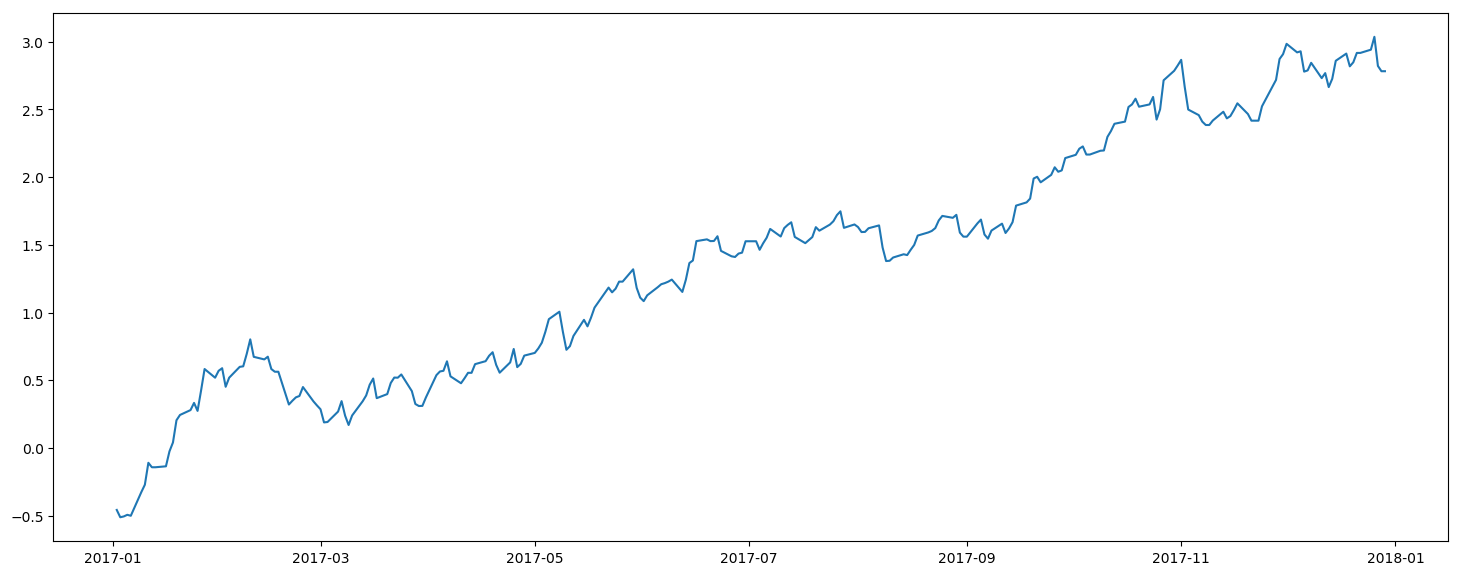

/Users/shaozhao/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


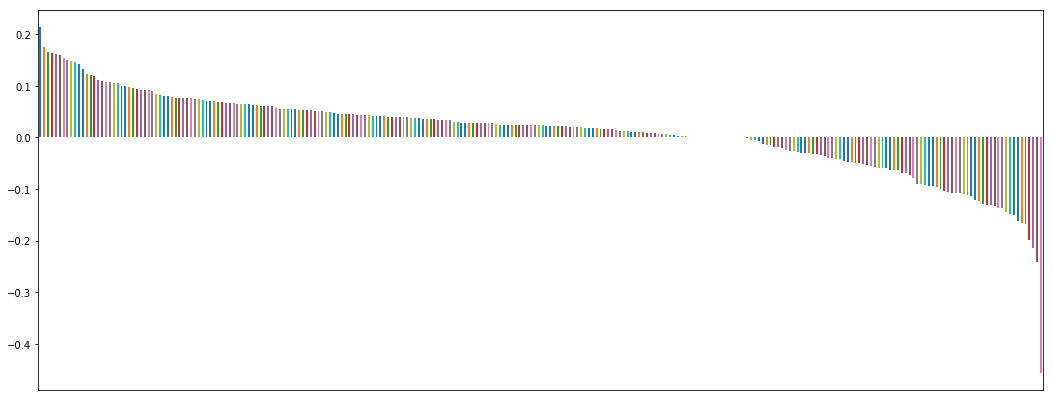

()

Minimum beginning balance = 10.775


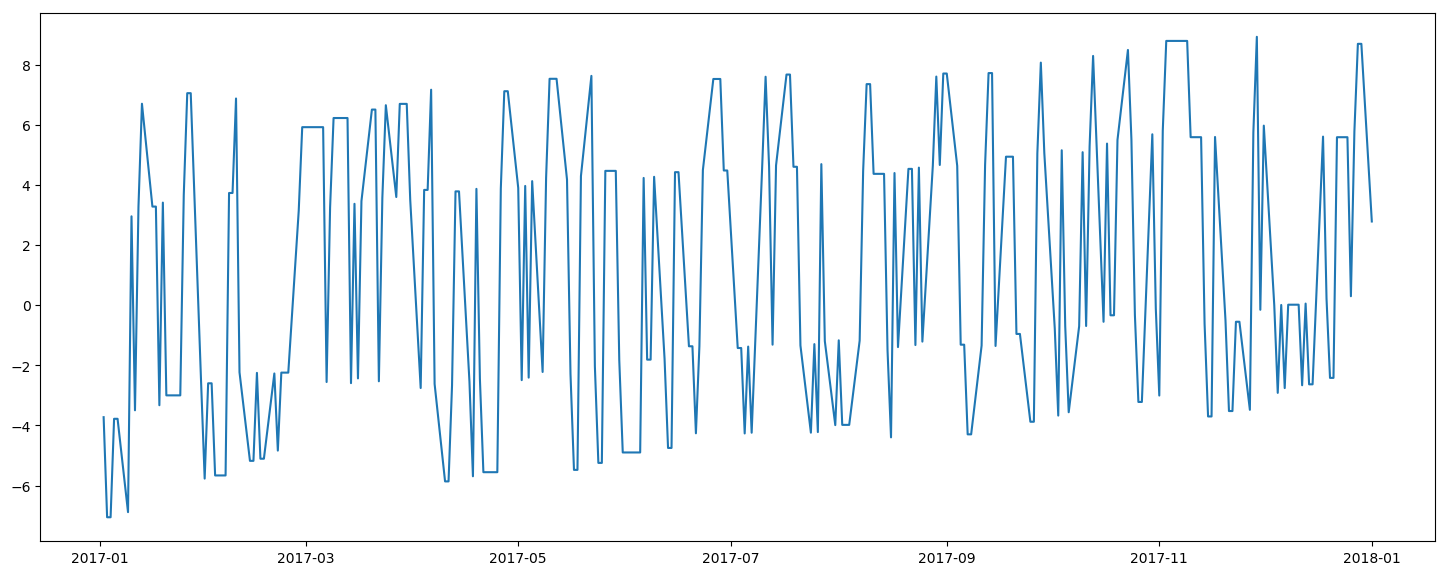

()

In [46]:
#Output
#Index of last trading day
ltd = max(result2.index.get_loc(result2.loc[result2['Day']==result2['buy_r'].last_valid_index()]['buy_r'][0]),
          result2.index.get_loc(result2.loc[result2['Day']==result2['sell_r'].last_valid_index()]['sell_r'][0]))

print(result2.iloc[ltd,0].strftime('Last contract cleared on %d, %b %Y'))

show(result2.loc[result2['Day'].isin(pd.date_range('2017-01-02','2017-12-29'))])
flow(result2.iloc[:ltd+1,[0,1,2,3,5,6,8]])

### 3.1.2 Fixed Two-day strategy

In [13]:
def fixed_2_buy(price, dataframe, alpha):
    a = ARIMA(dataframe, order=(1,1,1)).fit(trend='nc').forecast(steps=2, alpha=alpha)
    if price <= a[2][1][0]:
        return('buy')
    else:
        return('no buy')

In [14]:
def fixed_2_sell(price, dataframe, alpha):
    a = ARIMA(dataframe, order=(1,1,1)).fit(trend='nc').forecast(steps=2, alpha=alpha)
    if price >= a[2][1][1]:
        return('sell')
    else:
        return('no sell')

#### 3.1.2.a Fixed Two-day strategy with no risk control

In [15]:
result3 = df[5992:].copy()
result3['buy']=np.nan #2
result3['buy_r']=np.nan #3
result3['profit']=np.nan #4
result3['sell']=np.nan #5
result3['sell_r']=np.nan #6
result3['profit2']=np.nan #7
result3['opening']='no opening' #8
###

for i in range(0, 260):
    result3.iloc[i,2] = fixed_2_buy(result3.iloc[i,1], df.Price[0:i+5993], 1)
    result3.iloc[i,5] = fixed_2_sell(result3.iloc[i,1], df.Price[0:i+5993], 1)
    if result3.iloc[i,2] == 'buy':
        result3.iloc[i,3] = result3.iloc[i+2,0]
        result3.iloc[i,4] = result3.iloc[i+2,1]-result3.iloc[i,1]
    elif result3.iloc[i,5] == 'sell':
        result3.iloc[i,6] = result3.iloc[i+2,0]
        result3.iloc[i,7] = -result3.iloc[i+2,1]+result3.iloc[i,1]

/Users/shaozhao/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/shaozhao/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/shaozhao/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


In [16]:
result3.to_csv("result3.csv")

Last contract cleared on 02, Jan 2018


,Total profit,Yearly return,Min,Max,BM,Sharpe,Sortino,Volatility,BVolatility,%BM+,P/L,NProfit,NLoss,NP%
0,3.134,0.003946,-0.457,0.274,0.000491,0.108297,0.164982,0.031905,0.032503,0.554264,1.363808,148,110,0.573643


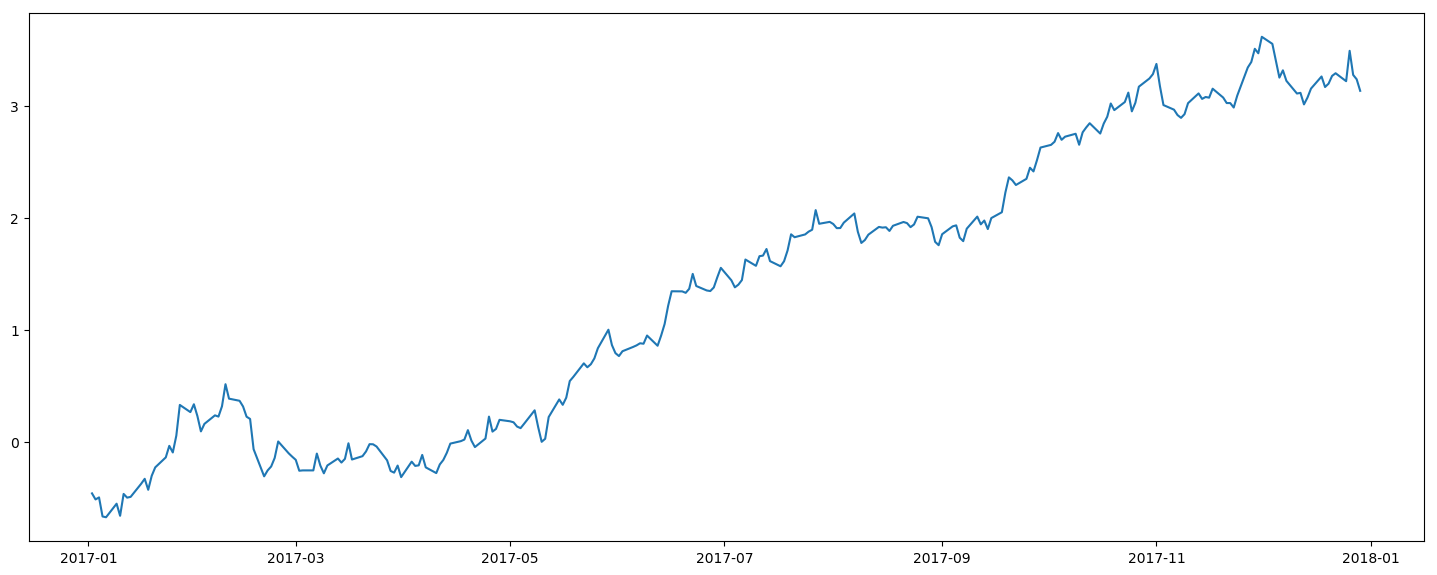

/Users/shaozhao/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


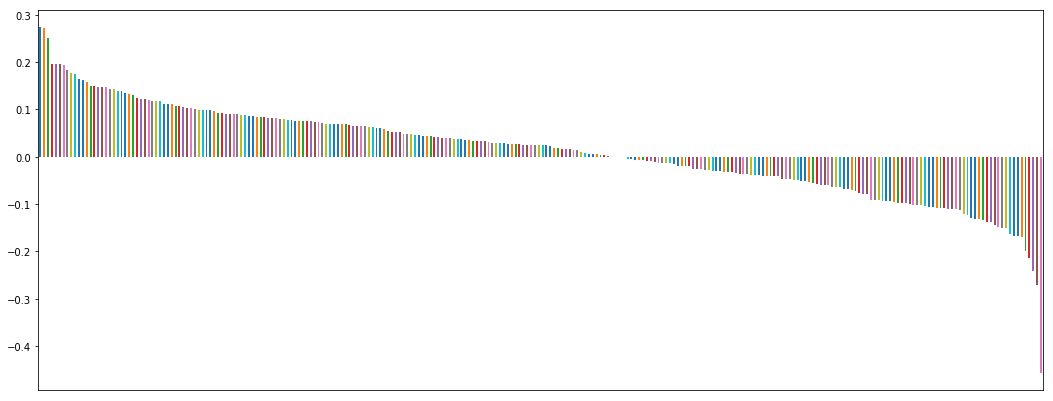

()

Minimum beginning balance = 10.775


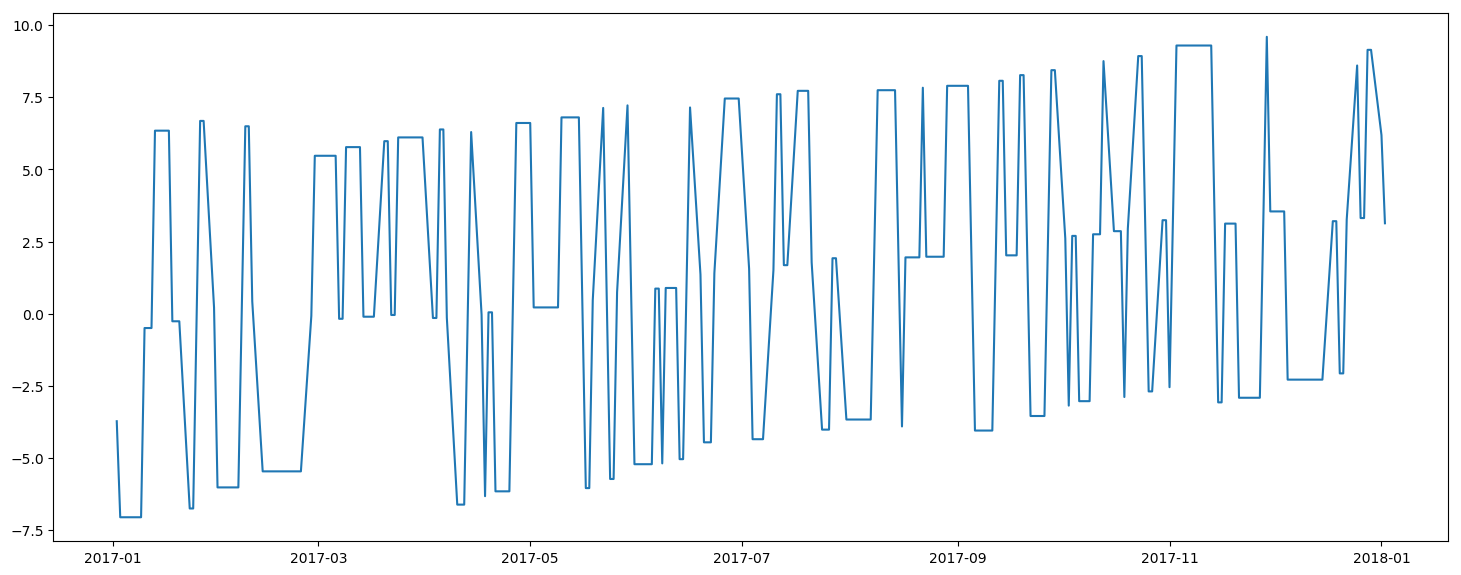

()

In [47]:
#Output
#Index of last trading day
ltd = max(result3.index.get_loc(result3.loc[result3['Day']==result3['buy_r'].last_valid_index()]['buy_r'][0]),
          result3.index.get_loc(result3.loc[result3['Day']==result3['sell_r'].last_valid_index()]['sell_r'][0]))

print(result3.iloc[ltd,0].strftime('Last contract cleared on %d, %b %Y'))

show(result3.loc[result3['Day'].isin(pd.date_range('2017-01-02','2017-12-29'))])
flow(result3.iloc[:ltd+1,[0,1,2,3,5,6,8]])

#### 3.1.2.b Fixed Two-day strategy with risk control

In [18]:
result4 = df[5992:].copy()
result4['buy']=np.nan #2
result4['buy_r']=np.nan #3
result4['profit']=np.nan #4
result4['sell']=np.nan #5
result4['sell_r']=np.nan #6
result4['profit2']=np.nan #7
result4['opening']='no opening' #8
###

for i in range(0, 260):
    result4.iloc[i,2] = fixed_2_buy(result4.iloc[i,1], df.Price[0:i+5993], 1)
    result4.iloc[i,5] = fixed_2_sell(result4.iloc[i,1], df.Price[0:i+5993], 1)
    if result4.iloc[i,2] == 'buy':
        if result4.iloc[i+2,1]-result4.iloc[i,1] >= 0:
            result4.iloc[i,3] = result4.iloc[i+2,0]
            result4.iloc[i,4] = result4.iloc[i+2,1]-result4.iloc[i,1]
        else:
            #skip one period
            result4.iloc[i,3] = result4.iloc[i+4,0]
            result4.iloc[i,4] = result4.iloc[i+4,1]-result4.iloc[i,1]
    elif result4.iloc[i,5] == 'sell':
        if -result4.iloc[i+2,1]+result4.iloc[i,1] >= 0:
            result4.iloc[i,6] = result4.iloc[i+2,0]
            result4.iloc[i,7] = -result4.iloc[i+2,1]+result4.iloc[i,1]
        else:
            #skip one period
            result4.iloc[i,6] = result4.iloc[i+4,0]
            result4.iloc[i,7] = -result4.iloc[i+4,1]+result4.iloc[i,1]

/Users/shaozhao/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/shaozhao/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/shaozhao/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


In [19]:
result4.to_csv("result4.csv")

Last contract cleared on 04, Jan 2018


,Total profit,Yearly return,Min,Max,BM,Sharpe,Sortino,Volatility,BVolatility,%BM+,P/L,NProfit,NLoss,NP%
0,5.701,0.007054,-0.439,0.274,0.000491,0.185408,0.222592,0.035399,0.032503,0.604651,1.670623,181,77,0.70155


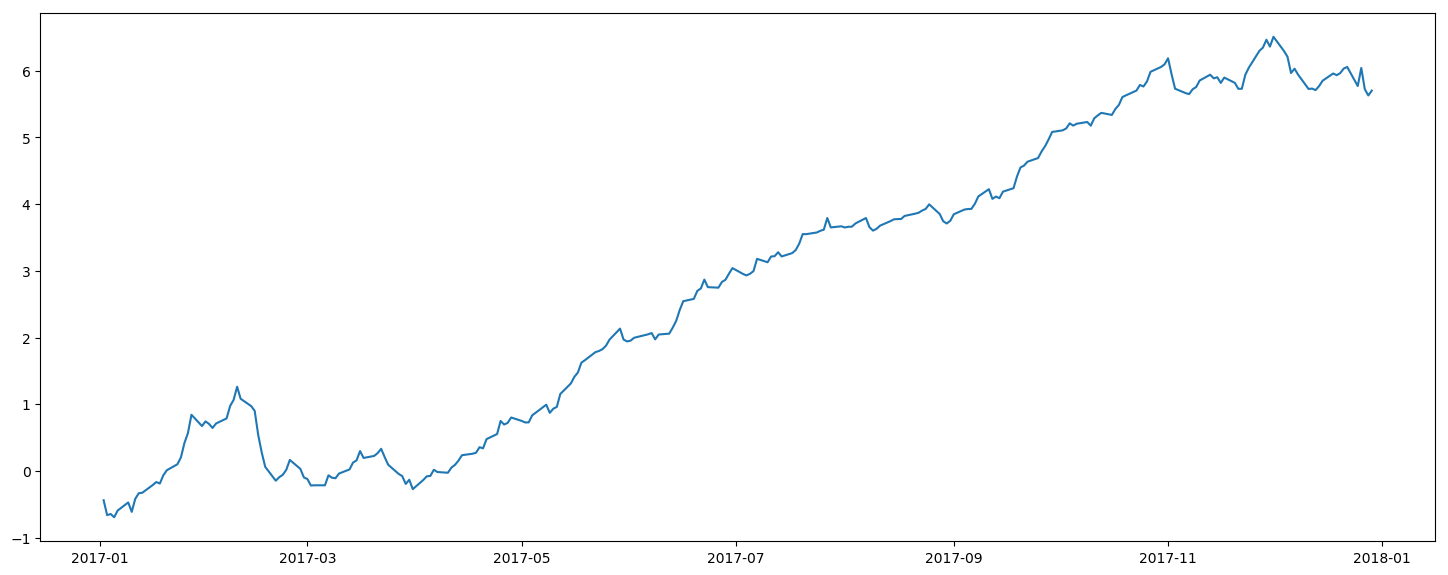

/Users/shaozhao/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


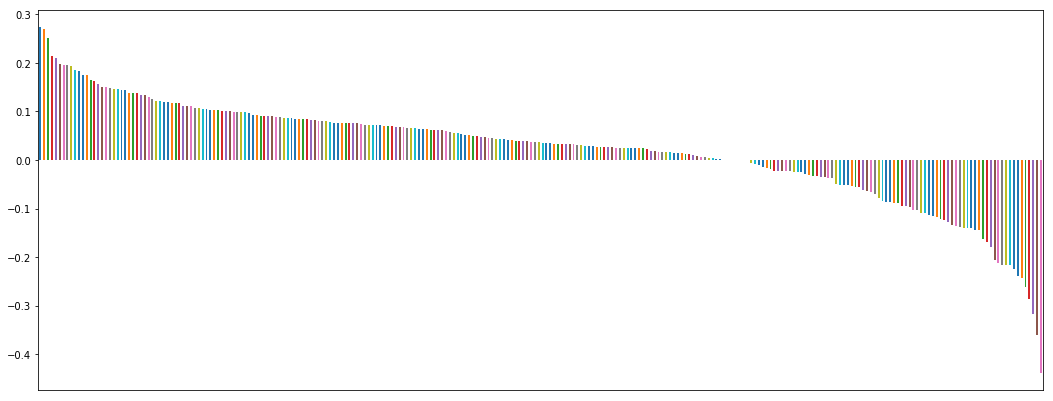

()

Minimum beginning balance = 17.314999999999998


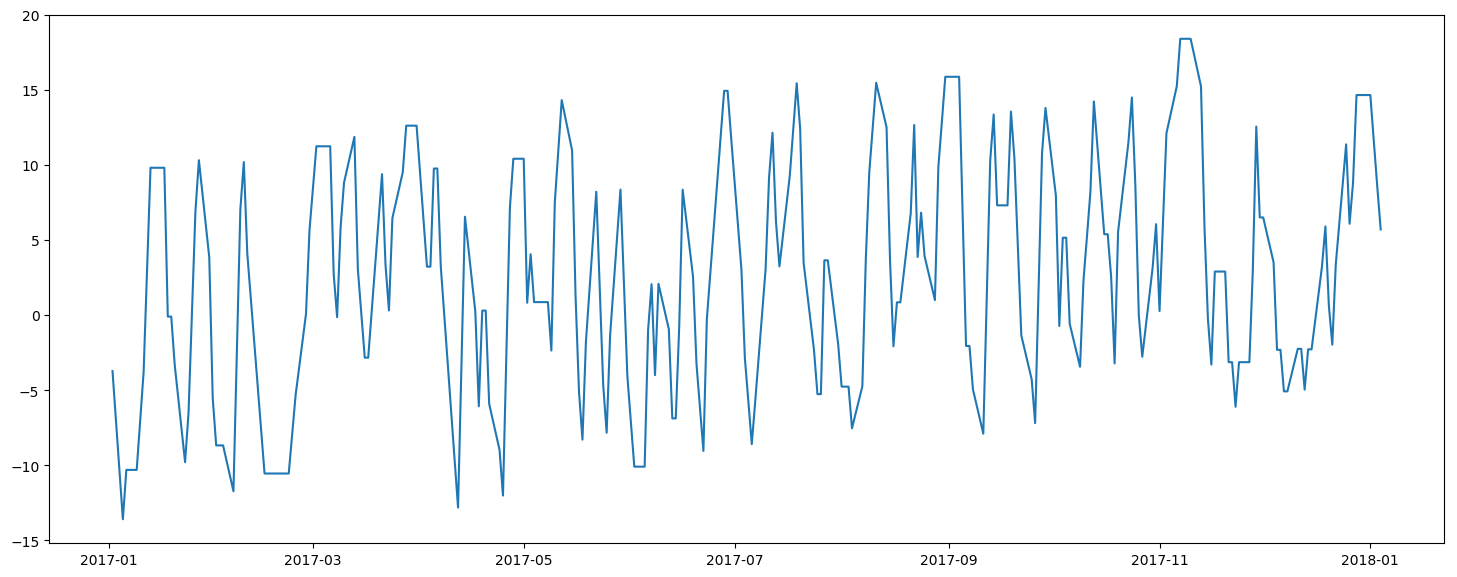

()

In [48]:
#Output
#Index of last trading day
ltd = max(result4.index.get_loc(result4.loc[result4['Day']==result4['buy_r'].last_valid_index()]['buy_r'][0]),
          result4.index.get_loc(result4.loc[result4['Day']==result4['sell_r'].last_valid_index()]['sell_r'][0]))

print(result4.iloc[ltd,0].strftime('Last contract cleared on %d, %b %Y'))

show(result4.loc[result4['Day'].isin(pd.date_range('2017-01-02','2017-12-29'))])
flow(result4.iloc[:ltd+1,[0,1,2,3,5,6,8]])

## 3.2 Flexible Strategy - No risk control vs Risk control

In [21]:
def forecast_7_buy(price, dataframe, alpha):
    a = ARIMA(dataframe, order=(1,1,1)).fit(trend='nc').forecast(steps=7, alpha=alpha)
    if price <= a[2][6][0]:
        return('buy')
    else:
        return('no buy')

In [22]:
def forecast_7_sell(price, dataframe, alpha):
    a = ARIMA(dataframe, order=(1,1,1)).fit(trend='nc').forecast(steps=7, alpha=alpha)
    if price >= a[2][6][1]:
        return('sell')
    else:
        return('no sell')

In [23]:
def buy_reverse(price, dataframe, alpha):
    a = ARIMA(dataframe, order=(1,1,1)).fit(trend='nc').forecast(steps=1, alpha=alpha)
    if price >= a[2][0][1]:
        return('reverse buy')
    else:
        return('no reverse buy')

In [24]:
def sell_reverse(price, dataframe, alpha):
    a = ARIMA(dataframe, order=(1,1,1)).fit(trend='nc').forecast(steps=1, alpha=alpha)
    if price <= a[2][0][0]:
        return('reverse sell')
    else:
        return('no reverse sell')

### 3.2.1 Flexible Strategy with no risk control

In [25]:
result5 = df[5992:].copy()
result5['buy']=np.nan #2
result5['buy_r']=np.nan #3
result5['profit']=np.nan #4
result5['sell']=np.nan #5
result5['sell_r']=np.nan #6
result5['profit2']=np.nan #7
result5['opening']='no opening' #8
###

#Plain without any risk control
for i in range(0, 260):
    result5.iloc[i,2] = forecast_7_buy(result5.iloc[i,1], df.Price[0:i+5993], 1)
    result5.iloc[i,5] = forecast_7_sell(result5.iloc[i,1], df.Price[0:i+5993], 1)
    if result5.iloc[i,2] == 'buy':
        for j in range(1,31):
            if j in range(1,8):
                t = buy_reverse(result5.iloc[i+j,1], df.Price[0:i+j+5992], 0.3)
                if t == 'reverse buy':
                    result5.iloc[i,3] = result5.iloc[i+j,0]
                    result5.iloc[i,4] = result5.iloc[i+j,1]-result5.iloc[i,1]
                    break
            elif j in range(8,15):
                t = buy_reverse(result5.iloc[i+j,1], df.Price[0:i+j+5992], 0.4)
                if t == 'reverse buy':
                    result5.iloc[i,3] = result5.iloc[i+j,0]
                    result5.iloc[i,4] = result5.iloc[i+j,1]-result5.iloc[i,1]
                    break
            elif j in range(15,22):
                t = buy_reverse(result5.iloc[i+j,1], df.Price[0:i+j+5992], 0.7)
                if t == 'reverse buy':
                    result5.iloc[i,3] = result5.iloc[i+j,0]
                    result5.iloc[i,4] = result5.iloc[i+j,1]-result5.iloc[i,1]
                    break
            else:
                result5.iloc[i,3] = result5.iloc[i+30,0]
                result5.iloc[i,4] = result5.iloc[i+30,1]-result5.iloc[i,1]
    elif result5.iloc[i,5] == 'sell':
        for j in range(1,31):
            if j in range(1,8):
                t = sell_reverse(result5.iloc[i+j,1], df.Price[0:i+j+5992], 0.3)
                if t == 'reverse sell':
                    result5.iloc[i,6] = result5.iloc[i+j,0]
                    result5.iloc[i,7] = -result5.iloc[i+j,1]+result5.iloc[i,1]
                    break
            elif j in range(8,15):
                t = sell_reverse(result5.iloc[i+j,1], df.Price[0:i+j+5992], 0.4)
                if t == 'reverse sell':
                    result5.iloc[i,6] = result5.iloc[i+j,0]
                    result5.iloc[i,7] = -result5.iloc[i+j,1]+result5.iloc[i,1]
                    break
            elif j in range(15,22):
                t = sell_reverse(result5.iloc[i+j,1], df.Price[0:i+j+5992], 0.7)
                if t == 'reverse sell':
                    result5.iloc[i,6] = result5.iloc[i+j,0]
                    result5.iloc[i,7] = -result5.iloc[i+j,1]+result5.iloc[i,1]
                    break
            else:
                result5.iloc[i,6] = result5.iloc[i+30,0]
                result5.iloc[i,7] = -result5.iloc[i+30,1]+result5.iloc[i,1]

/Users/shaozhao/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/shaozhao/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/shaozhao/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


In [26]:
result5.to_csv("result5.csv")

Last contract cleared on 09, Feb 2018


,Total profit,Yearly return,Min,Max,BM,Sharpe,Sortino,Volatility,BVolatility,%BM+,P/L,NProfit,NLoss,NP%
0,10.396,0.013729,-0.503,0.827,0.000491,0.172802,0.287003,0.076606,0.032503,0.596899,1.582933,169,91,0.65


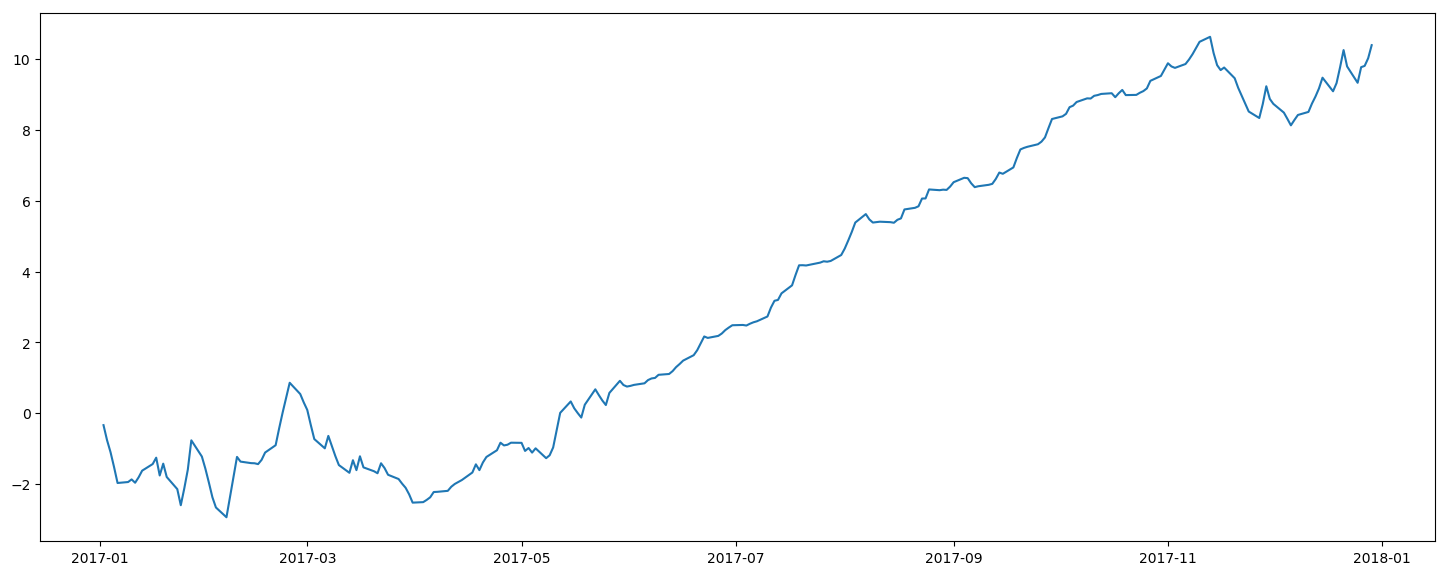

/Users/shaozhao/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


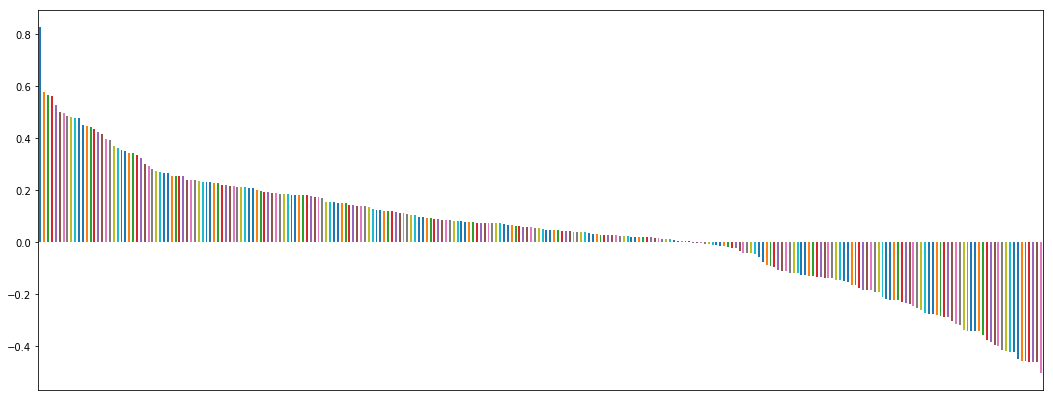

()

Minimum beginning balance = 63.684


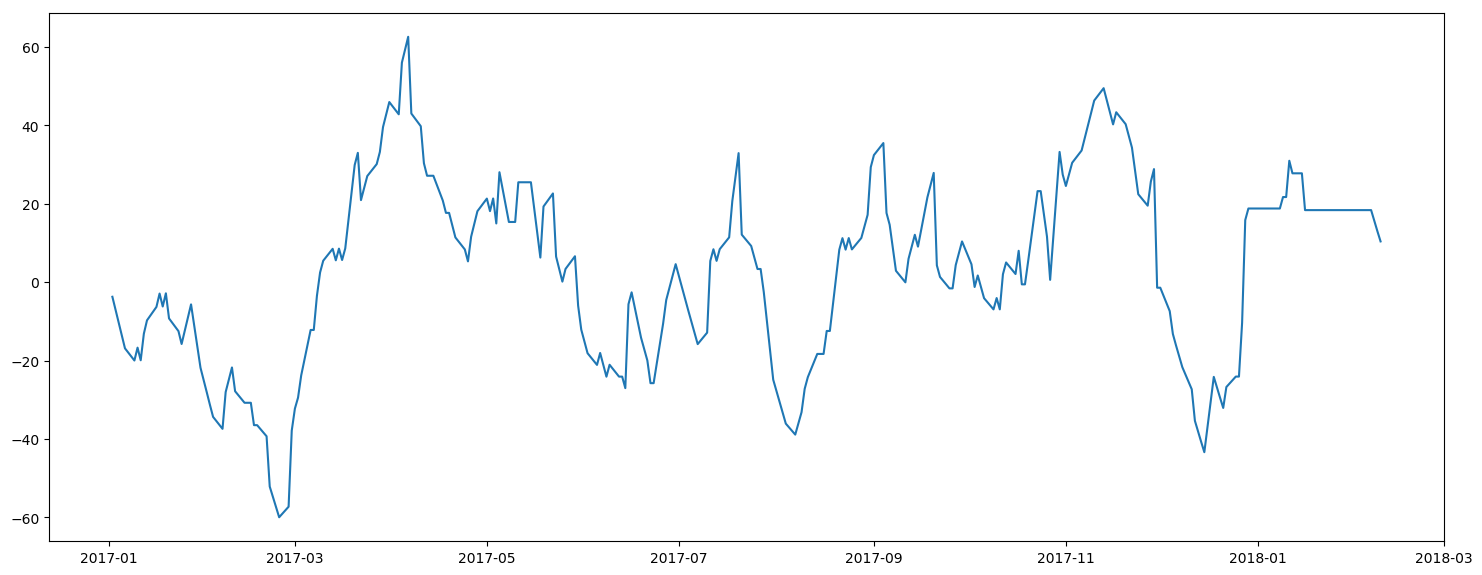

()

In [49]:
#Output
#Index of last trading day
ltd = max(result5.index.get_loc(result5.loc[result5['Day']==result5['buy_r'].last_valid_index()]['buy_r'][0]),
          result5.index.get_loc(result5.loc[result5['Day']==result5['sell_r'].last_valid_index()]['sell_r'][0]))

print(result5.iloc[ltd,0].strftime('Last contract cleared on %d, %b %Y'))

show(result5.loc[result5['Day'].isin(pd.date_range('2017-01-02','2017-12-29'))])
flow(result5.iloc[:ltd+1,[0,1,2,3,5,6,8]])

### 3.2.2 Flexible Strategy with risk control

In [50]:
result6 = df[5992:].copy()
result6['buy']=np.nan #2
result6['buy_r']=np.nan #3
result6['profit']=np.nan #4
result6['sell']=np.nan #5
result6['sell_r']=np.nan #6
result6['profit2']=np.nan #7
result6['opening']='no opening' #8
###

#With risk control
for i in range(0, 260):
    result6.iloc[i,2] = forecast_7_buy(result6.iloc[i,1], df.Price[0:i+5993], 1)
    result6.iloc[i,5] = forecast_7_sell(result6.iloc[i,1], df.Price[0:i+5993], 1)
    if result6.iloc[i,2] == 'buy':
        for j in range(1,31):
            if j in range(1,8):
                t = buy_reverse(result6.iloc[i+j,1], df.Price[0:i+j+5992], 0.3)
                if t == 'reverse buy' and (result6.iloc[i+j,1]/result6.iloc[i,1])>=1:
                    result6.iloc[i,3] = result6.iloc[i+j,0]
                    result6.iloc[i,4] = result6.iloc[i+j,1]-result6.iloc[i,1]
                    break
            elif j in range(8,15):
                t = buy_reverse(result6.iloc[i+j,1], df.Price[0:i+j+5992], 0.4)
                if t == 'reverse buy' and (result6.iloc[i+j,1]/result6.iloc[i,1])>=1:
                    result6.iloc[i,3] = result6.iloc[i+j,0]
                    result6.iloc[i,4] = result6.iloc[i+j,1]-result6.iloc[i,1]
                    break
            elif j in range(15,22):
                t = buy_reverse(result6.iloc[i+j,1], df.Price[0:i+j+5992], 0.7)
                if t == 'reverse buy' and (result6.iloc[i+j,1]/result6.iloc[i,1])>=0.9:
                    result6.iloc[i,3] = result6.iloc[i+j,0]
                    result6.iloc[i,4] = result6.iloc[i+j,1]-result6.iloc[i,1]
                    break
            else:
                result6.iloc[i,3] = result6.iloc[i+30,0]
                result6.iloc[i,4] = result6.iloc[i+30,1]-result6.iloc[i,1]
    elif result6.iloc[i,5] == 'sell':
        for j in range(1,31):
            if j in range(1,8):
                t = sell_reverse(result6.iloc[i+j,1], df.Price[0:i+j+5992], 0.3)
                if t == 'reverse sell' and (result6.iloc[i,1]/result6.iloc[i+j,1])>=1:
                    result6.iloc[i,6] = result6.iloc[i+j,0]
                    result6.iloc[i,7] = -result6.iloc[i+j,1]+result6.iloc[i,1]
                    break
            elif j in range(8,15):
                t = sell_reverse(result6.iloc[i+j,1], df.Price[0:i+j+5992], 0.4)
                if t == 'reverse sell' and (result6.iloc[i,1]/result6.iloc[i+j,1])>=1:
                    result6.iloc[i,6] = result6.iloc[i+j,0]
                    result6.iloc[i,7] = -result6.iloc[i+j,1]+result6.iloc[i,1]
                    break
            elif j in range(15,22):
                t = sell_reverse(result6.iloc[i+j,1], df.Price[0:i+j+5992], 0.7)
                if t == 'reverse sell' and (result6.iloc[i,1]/result6.iloc[i+j,1])>=0.9:
                    result6.iloc[i,6] = result6.iloc[i+j,0]
                    result6.iloc[i,7] = -result6.iloc[i+j,1]+result6.iloc[i,1]
                    break
            else:
                result6.iloc[i,6] = result6.iloc[i+30,0]
                result6.iloc[i,7] = -result6.iloc[i+30,1]+result6.iloc[i,1]

/Users/shaozhao/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/shaozhao/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/shaozhao/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


In [51]:
result6.to_csv("result6.csv")

Last contract cleared on 09, Feb 2018


,Total profit,Yearly return,Min,Max,BM,Sharpe,Sortino,Volatility,BVolatility,%BM+,P/L,NProfit,NLoss,NP%
0,10.729,0.014222,-0.886,0.827,0.000491,0.177056,0.260563,0.077553,0.032503,0.600775,1.616811,169,91,0.65


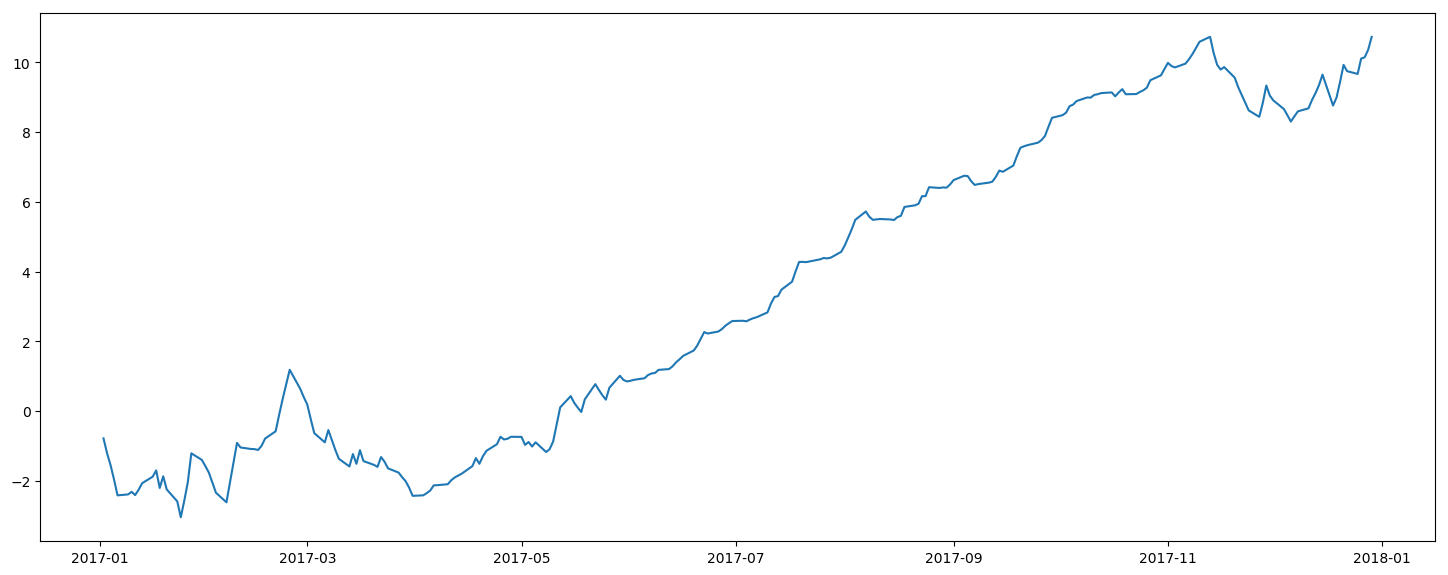

/Users/shaozhao/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


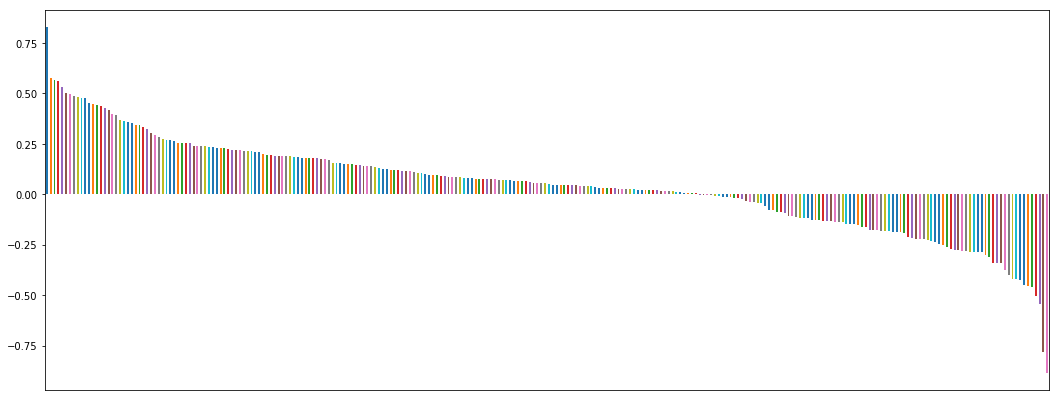

()

Minimum beginning balance = 64.12599999999999


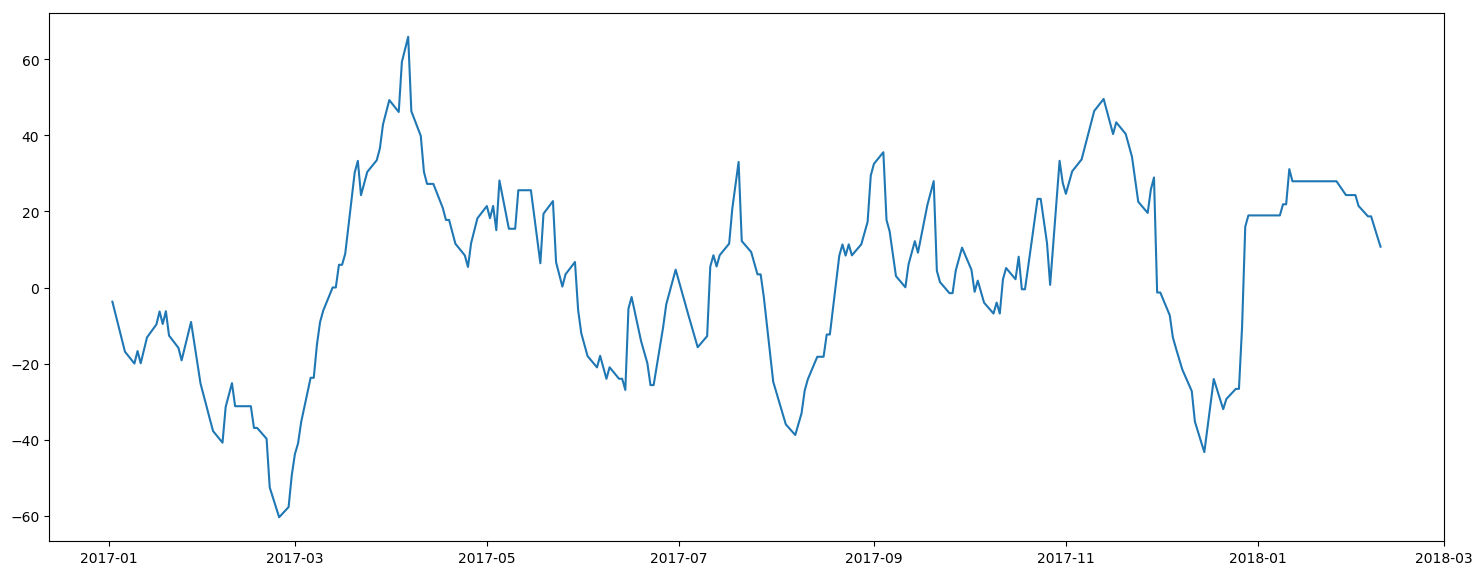

()

In [52]:
#Output
#Index of last trading day
ltd = max(result6.index.get_loc(result6.loc[result6['Day']==result6['buy_r'].last_valid_index()]['buy_r'][0]),
          result6.index.get_loc(result6.loc[result6['Day']==result6['sell_r'].last_valid_index()]['sell_r'][0]))

print(result6.iloc[ltd,0].strftime('Last contract cleared on %d, %b %Y'))

show(result6.loc[result6['Day'].isin(pd.date_range('2017-01-02','2017-12-29'))])
flow(result6.iloc[:ltd+1,[0,1,2,3,5,6,8]])

### 3.3 Opening Strategy

In [53]:
def opening(price1, price2, beta):
    if abs((price1-price2)/price2) <= beta:
        return('opening')
    else:
        return('no opening')

In [54]:
def fixed_2_buy(price, dataframe, alpha):
    a = ARIMA(dataframe, order=(1,1,1)).fit(trend='nc').forecast(steps=2, alpha=alpha)
    if price <= a[2][1][0]:
        return('buy')
    else:
        return('no buy')

In [55]:
def fixed_2_sell(price, dataframe, alpha):
    a = ARIMA(dataframe, order=(1,1,1)).fit(trend='nc').forecast(steps=2, alpha=alpha)
    if price >= a[2][1][1]:
        return('sell')
    else:
        return('no sell')

### 3.3.1 Opening in low volatility

In [56]:
result7 = df[5987:].copy()
result7['buy']=np.nan #2
result7['buy_r']=np.nan #3
result7['profit']=np.nan #4
result7['sell']=np.nan #5
result7['sell_r']=np.nan #6
result7['profit2']=np.nan #7
result7['opening']=np.nan #8
###

#Opening strategy with beta of 0.05 (beta ∈ [-11%, 8%])
for i in range(5, 265):
    result7.iloc[i,2] = fixed_2_buy(result7.iloc[i,1], df.Price[0:i+5993], 1)
    result7.iloc[i,5] = fixed_2_sell(result7.iloc[i,1], df.Price[0:i+5993], 1)
    #Decide to add from the second trading day
    if i != 5:
        result7.iloc[i,8] = opening(result7.iloc[i,1], result7.iloc[i-5,1], 0.05)
    if result7.iloc[i,2] == 'buy':
        if result7.iloc[i,8] == 'opening':
            result7.iloc[i,3] = result7.iloc[i+2,0]
            result7.iloc[i,4] = result7.iloc[i+2,1]*2-result7.iloc[i+1,1]-result7.iloc[i,1]
        else:
            result7.iloc[i,3] = result7.iloc[i+2,0]
            result7.iloc[i,4] = result7.iloc[i+2,1]-result7.iloc[i,1]
    elif result7.iloc[i,5] == 'sell':
        if result7.iloc[i,8] == 'opening':
            result7.iloc[i,6] = result7.iloc[i+2,0]
            result7.iloc[i,7] = -result7.iloc[i+2,1]*2+result7.iloc[i+1,1]+result7.iloc[i,1]
        else:
            result7.iloc[i,6] = result7.iloc[i+2,0]
            result7.iloc[i,7] = -result7.iloc[i+2,1]+result7.iloc[i,1]

/Users/shaozhao/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/shaozhao/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/shaozhao/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


In [57]:
result7.to_csv("result7.csv")

Last contract cleared on 02, Jan 2018


,Total profit,Yearly return,Min,Max,BM,Sharpe,Sortino,Volatility,BVolatility,%BM+,P/L,NProfit,NLoss,NP%
0,16.088,0.020564,-0.262,0.457,0.000491,0.494736,1.08136,0.040573,0.032503,0.635659,3.730931,174,84,0.674419


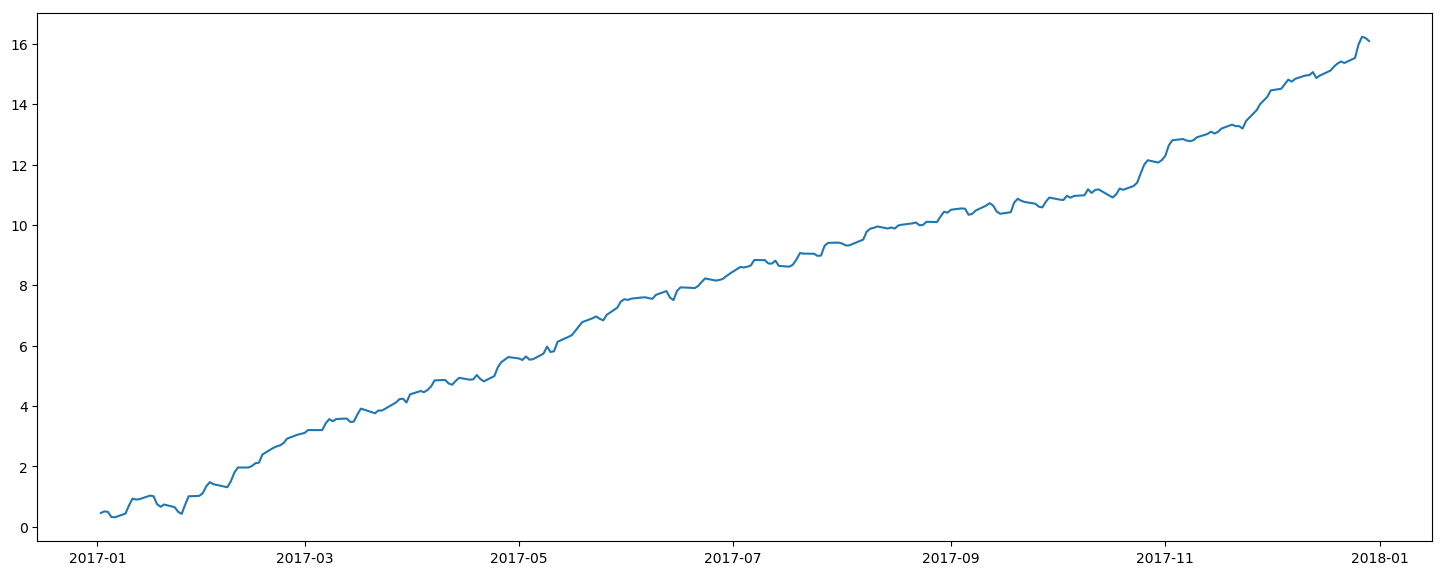

/Users/shaozhao/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


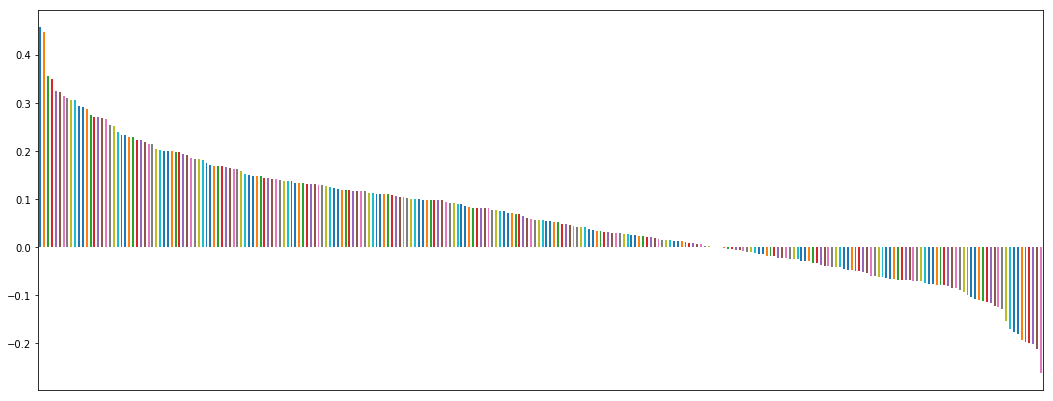

()

Minimum beginning balance = 9.343


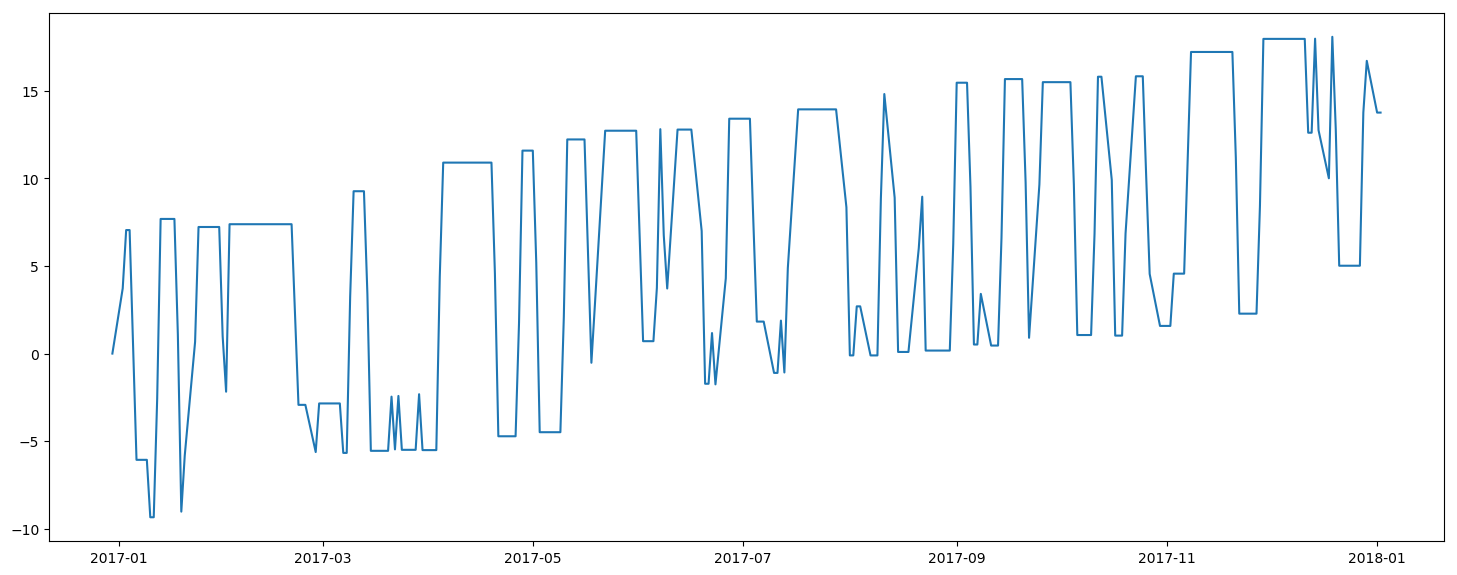

()

In [58]:
#Output
#Index of last trading day
ltd = max(result7.index.get_loc(result7.loc[result7['Day']==result7['buy_r'].last_valid_index()]['buy_r'][0]),
          result7.index.get_loc(result7.loc[result7['Day']==result7['sell_r'].last_valid_index()]['sell_r'][0]))

print(result7.iloc[ltd,0].strftime('Last contract cleared on %d, %b %Y'))

show(result7.loc[result7['Day'].isin(pd.date_range('2017-01-02','2017-12-29'))])
flow(result7.iloc[4:ltd+1,[0,1,2,3,5,6,8]])

### 3.3.2 Opening strategy Optimization

In [9]:
result8 = df[5987:].copy()
result8['buy']=np.nan #2
result8['buy_r']=np.nan #3
result8['profit']=np.nan #4
result8['sell']=np.nan #5
result8['sell_r']=np.nan #6
result8['profit2']=np.nan #7
result8['opening']=np.nan #8
###

#Opening strategy Optimization - beta ∈ [-11%, 8%]
op = {}
for beta in np.arange(0.0, 0.12, 0.01):
    for i in range(5, 265):
        result8.iloc[i,2] = fixed_2_buy(result8.iloc[i,1], df.Price[0:i+5993], 1)
        result8.iloc[i,5] = fixed_2_sell(result8.iloc[i,1], df.Price[0:i+5993], 1)
        if i != 5:
            result8.iloc[i,8] = opening(result8.iloc[i,1], result8.iloc[i-5,1], beta)
        if result8.iloc[i,2] == 'buy':
            if result8.iloc[i,8] == 'opening':
                result8.iloc[i,3] = result8.iloc[i+2,0]
                result8.iloc[i,4] = result8.iloc[i+2,1]*2-result8.iloc[i+1,1]-result8.iloc[i,1]
            else:
                result8.iloc[i,3] = result8.iloc[i+2,0]
                result8.iloc[i,4] = result8.iloc[i+2,1]-result8.iloc[i,1]
        elif result8.iloc[i,5] == 'sell':
            if result8.iloc[i,8] == 'opening':
                result8.iloc[i,6] = result8.iloc[i+2,0]
                result8.iloc[i,7] = -result8.iloc[i+2,1]*2+result8.iloc[i+1,1]+result8.iloc[i,1]
            else:
                result8.iloc[i,6] = result8.iloc[i+2,0]
                result8.iloc[i,7] = -result8.iloc[i+2,1]+result8.iloc[i,1]
    op[beta] = result8.profit.sum() + result8.profit2.sum()

#Output
print(op)
print('Optimized beta =',max(op, key=lambda key: op[key]))

/Users/shaozhao/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/shaozhao/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/shaozhao/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


{0.0: 11.621999999999995, 0.01: 12.754999999999994, 0.02: 14.250999999999992, 0.03: 14.960999999999993, 0.04: 15.715999999999994, 0.05: 16.087999999999994, 0.06: 16.831999999999994, 0.07: 17.276999999999994, 0.08: 17.60899999999999, 0.09: 17.57699999999999, 0.1: 17.679999999999993, 0.11: 17.68699999999999}
Optimized beta = 0.11


In [62]:
result9 = df[5987:].copy()
result9['buy']=np.nan #2
result9['buy_r']=np.nan #3
result9['profit']=np.nan #4
result9['sell']=np.nan #5
result9['sell_r']=np.nan #6
result9['profit2']=np.nan #7
result9['opening']=np.nan #8
###

#Execution with optimized beta
opbeta = max(op, key=lambda key: op[key])

for i in range(5, 265):
        result9.iloc[i,2] = fixed_2_buy(result9.iloc[i,1], df.Price[0:i+5993], 1)
        result9.iloc[i,5] = fixed_2_sell(result9.iloc[i,1], df.Price[0:i+5993], 1)
        if i != 5:
            result9.iloc[i,8] = opening(result9.iloc[i,1], result9.iloc[i-5,1], opbeta)
        if result9.iloc[i,2] == 'buy':
            if result9.iloc[i,8] == 'opening':
                result9.iloc[i,3] = result9.iloc[i+2,0]
                result9.iloc[i,4] = result9.iloc[i+2,1]*2-result9.iloc[i+1,1]-result9.iloc[i,1]
            else:
                result9.iloc[i,3] = result9.iloc[i+2,0]
                result9.iloc[i,4] = result9.iloc[i+2,1]-result9.iloc[i,1]
        elif result9.iloc[i,5] == 'sell':
            if result9.iloc[i,8] == 'opening':
                result9.iloc[i,6] = result9.iloc[i+2,0]
                result9.iloc[i,7] = -result9.iloc[i+2,1]*2+result9.iloc[i+1,1]+result9.iloc[i,1]
            else:
                result9.iloc[i,6] = result9.iloc[i+2,0]
                result9.iloc[i,7] = -result9.iloc[i+2,1]+result9.iloc[i,1]

/Users/shaozhao/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/shaozhao/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/shaozhao/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


In [63]:
result9.to_csv("result9.csv")

Optimized beta = 0.11
Last contract cleared on 02, Jan 2018


,Total profit,Yearly return,Min,Max,BM,Sharpe,Sortino,Volatility,BVolatility,%BM+,P/L,NProfit,NLoss,NP%
0,17.687,0.022625,-0.262,0.54,0.000491,0.497393,1.128065,0.044501,0.032503,0.639535,3.701133,173,85,0.670543


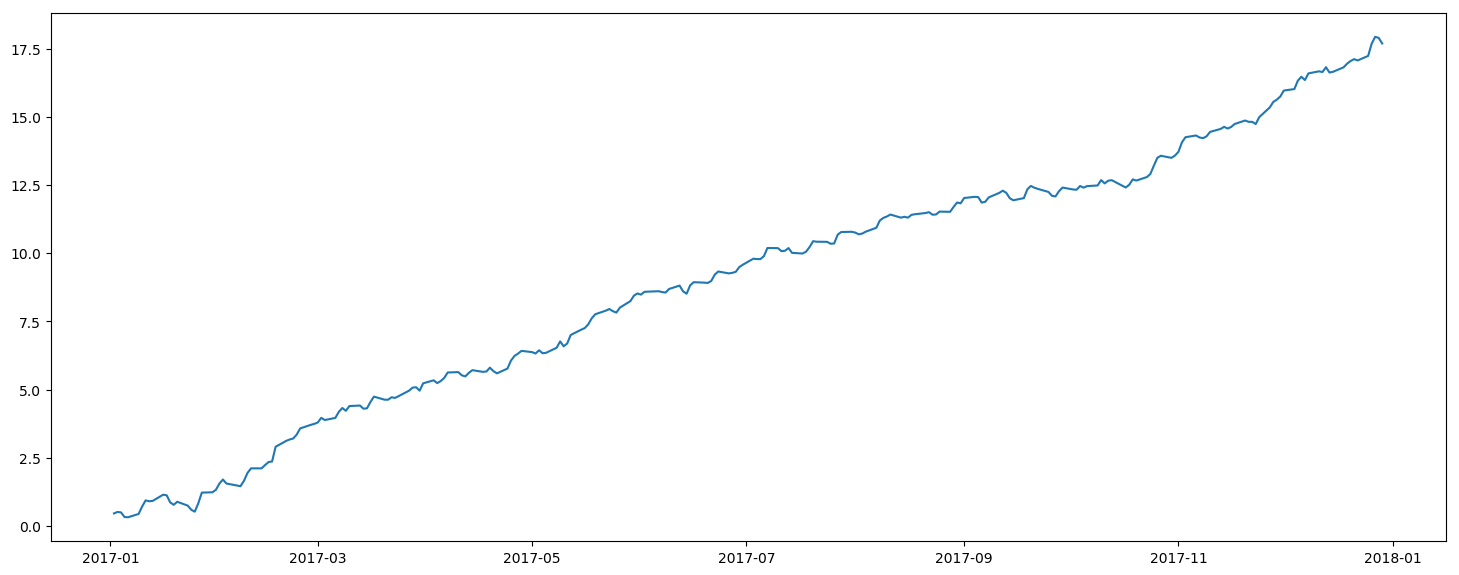

/Users/shaozhao/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


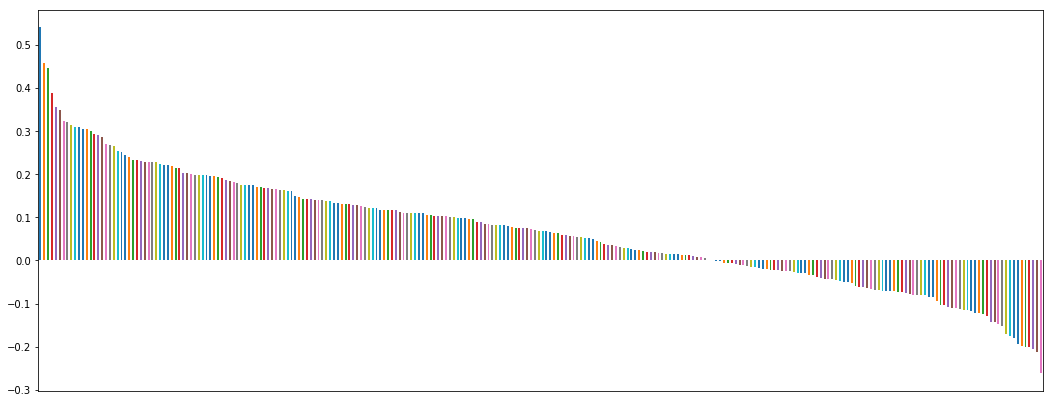

()

Minimum beginning balance = 9.343


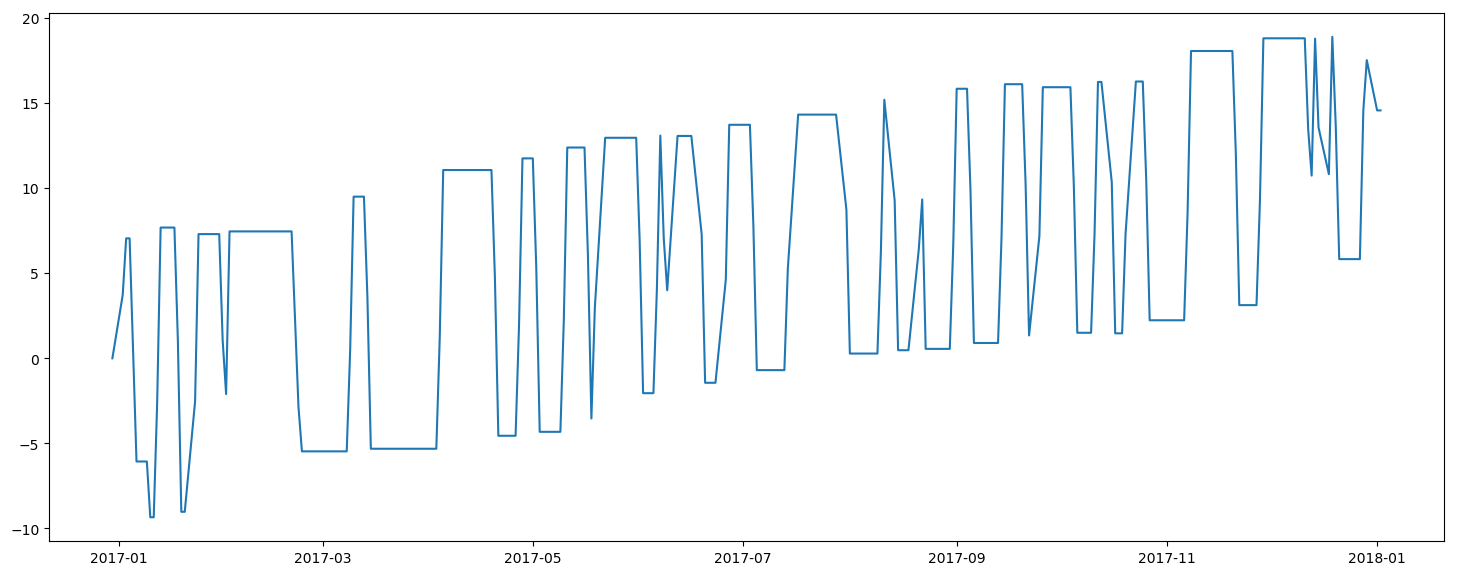

()

In [64]:
#Output
#Index of last trading day
ltd = max(result9.index.get_loc(result9.loc[result9['Day']==result9['buy_r'].last_valid_index()]['buy_r'][0]),
          result9.index.get_loc(result9.loc[result9['Day']==result9['sell_r'].last_valid_index()]['sell_r'][0]))

print('Optimized beta =', opbeta)
print(result9.iloc[ltd,0].strftime('Last contract cleared on %d, %b %Y'))

show(result9.loc[result9['Day'].isin(pd.date_range('2017-01-02','2017-12-29'))])
flow(result9.iloc[4:ltd+1,[0,1,2,3,5,6,8]])

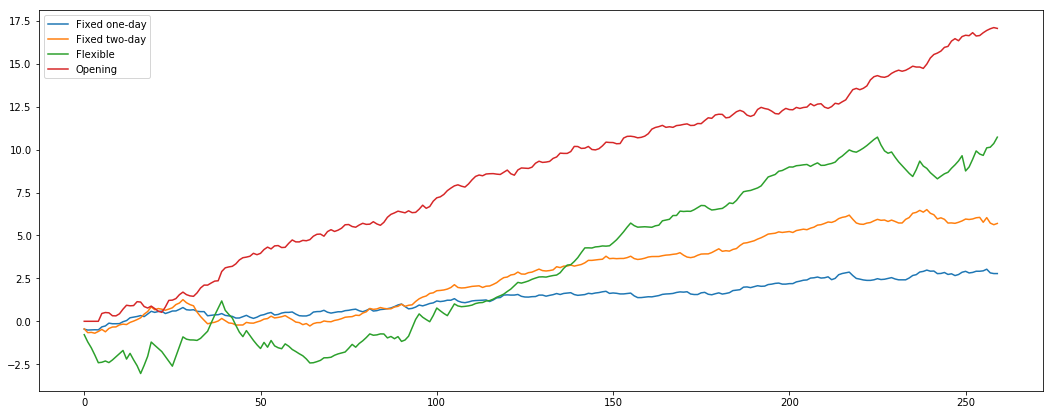

In [78]:
profit2 = pd.read_csv('profit2.csv')
profit4 = pd.read_csv('profit4.csv')
profit6 = pd.read_csv('profit6.csv')
profit9 = pd.read_csv('profit9.csv')

plt.figure(figsize=(18,7))
plt.plot(profit2.Profit.cumsum(), label='Fixed one-day')
plt.plot(profit4.Profit.cumsum(), label='Fixed two-day')
plt.plot(profit6.Profit.cumsum(), label='Flexible')
plt.plot(profit9.Profit.cumsum(), label='Opening')
plt.legend(loc='best')
plt.show()